## packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
import matplotlib.collections as collections
from numpy.fft import fft, ifft, fftshift, fftfreq
import pywt
from scipy import signal
import matplotlib as mpl

# from sklearn.linear_model import LinearRegression

## funciones

In [3]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x  

In [4]:
def to_density(z, sal, temp, lat):
    p = gsw.p_from_z(-z, lat)
    rho = gsw.rho_t_exact(sal, temp, p)
    return rho

In [5]:
def earth_to_uv(dfe, dfn, a): 
    "This takes 2 dataframes of east and north coordinates respectively and the regresion coeficient and transforms them to the direction of the coeficient"
    alpha = np.arctan(a) #Ángulo
    t, b = dfe.shape 
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]]) #Matriz de transfomación
    columns = dfe.columns
    u = np.zeros((0,t)) #Inicialización de variables
    v = np.zeros((0,t)) #Inicialización de variables
    for i in columns: #Iteración sobre las columnas de los dataframes
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]]) # Matriz de coordenadas east-north
        ui, vi = np.tensordot(M, bin_, 1) #Multiplicación matricial
        u = np.concatenate((u, ui), axis=0) #Unión de los resultados de u
        v = np.concatenate((v, vi), axis=0)#Unión de los resultados de v
    return u, v

In [6]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [7]:
def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s

In [8]:
def spectrum3(h, dt=1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)

In [9]:
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=10, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [10]:
def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

# Importar y arreglar datos

In [11]:
feb16 = xr.open_dataset("data/adcp2012feb.nc")
newfeb = feb16.sel(time=slice("2012-02-17","2012-03-08"))

UV_burst = xr.open_dataset("data/UV_burst.nc")
EN_burst = xr.open_dataset("data/EastNorth_burst.nc")

In [12]:
#Convertir velocidades a DataFrames
columnas = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25']

df_east = pd.DataFrame(EN_burst.east.values, columns = columnas)
df_east.index = EN_burst.time.values

df_north = pd.DataFrame(EN_burst.north.values, columns = columnas)
df_north.index = EN_burst.time.values

u, v = earth_to_uv(df_east, df_north, 1.13493621)

df_u = pd.DataFrame(np.transpose(u), columns = columnas)
df_u.index = EN_burst.time.values

df_v = pd.DataFrame(np.transpose(v), columns = columnas)
df_v.index = EN_burst.time.values

In [13]:
# DC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
# NM = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
# ML = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
# PC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

DC = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
NM = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
ML = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
PC = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

In [14]:
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])
DC_2 = to_data(DC['tdate_dc2'], DC['da_dc2'], DC['s_dc2'], DC['temp_dc2'])
DC_3 = to_data(DC['tdate_dc3'], DC['da_dc3'], DC['s_dc3'], DC['temp_dc3'])
DC_4 = to_data(DC['tdate_dc4'], DC['da_dc4'], DC['s_dc4'], DC['temp_dc4'])

NM_1 = to_data(NM['tdate_nm1'], NM['da_nm1'], NM['s_nm1'], NM['temp_nm1'])
NM_2 = to_data(NM['tdate_nm2'], NM['da_nm2'], NM['s_nm2'], NM['temp_nm2'])
NM_3 = to_data(NM['tdate_nm3'], NM['da_nm3'], NM['s_nm3'], NM['temp_nm3'])

ML_1 = to_data(ML['tdate_ac1'], ML['da_ac1'], ML['s_ac1'], ML['temp_ac1'])
ML_2 = to_data(ML['tdate_ac2'], ML['da_ac2'], ML['s_ac2'], ML['temp_ac2'])

PC_1 = to_data(PC['tdate_pc'], PC['da_pc'], PC['s_pc'], PC['temp_pc'])



In [15]:
Delta_nmdc = (NM_1["Depth"] - NM_1["Depth"].mean()) - (DC_1["Depth"] - DC_1["Depth"].mean())
Delta_nmdc = Delta_nmdc.rolling(window=10,center=False).mean()

In [16]:
#Viento
df2 = pd.read_table('C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120301.dat', sep=",", header=[1, 2, 3])
df2 = pd.DataFrame(df2.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df2 = df2.set_index('TIMESTAMP')
df3 = pd.read_table('C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120419.dat', sep=",", header=[1, 2, 3])
df3 = pd.DataFrame(df3.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df3 = df3.set_index('TIMESTAMP')
result = pd.concat([df2, df3], ignore_index=False, sort=False)
result.index = pd.to_datetime(result.index)
w = result

In [17]:
north_w = np.float64(w['Speed'])*np.sin(np.pi*np.float64(w['Direction'])/180)
east_w = np.float64(w['Speed'])*np.cos(np.pi*np.float64(w['Direction'])/180)
north_w = pd.DataFrame(data=north_w, columns=['viento'])
east_w = pd.DataFrame(data=east_w, columns=['viento'])

uw, vw = earth_to_uv(east_w, north_w, 0.79970532)

dfw = pd.DataFrame(np.transpose(np.array([uw[0,:], vw[0,:]])), columns=['u', 'v'])
dfw.index = w.index

In [18]:
#Leer datos caudal
Q = pd.read_csv("data\\febmar2012.csv")
lista_nombres= ["nan1", "fecha", "nan2", "sensor", 
                "caudal", "A"]
Q.columns=lista_nombres
Q = Q.drop(columns=['nan1', 'nan2', 'sensor', 'A']).reset_index()
Q = Q.drop(columns=['level_0', 'level_1'])
Q["fecha"] = pd.to_datetime(Q["fecha"].values)

In [19]:
#Importar caudal de pescadero cada 15 min en GMT
# https://nwis.waterservices.usgs.gov/nwis/iv/?sites=11162500&parameterCd=00060&startDT=2011-07-07T00:00:00.000-07:00&endDT=2012-07-07T23:59:59.999-07:00&siteStatus=all&format=rdb
Q = pd.read_csv("data\\caudal2012.csv", sep=';')
Q = Q.drop(['5s', '15s', '14n', 'Unnamed: 6'], axis=1)
Q['index'] = pd.to_datetime(Q['20d'] + ' ' + Q['6s'], format='%d-%m-%Y %H:%M')
Q = Q.set_index('index')
Q = Q.drop(['20d', '6s'], axis=1)

In [20]:
#Importar nivel de agua cada 6 min en hora local
snfco = pd.read_csv("data/CO-OPS_9414290_met.csv")
snfco = snfco.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
snfco['index'] = pd.to_datetime(snfco['Date'] + ' ' + snfco['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
snfco = snfco.set_index('index')
snfco = snfco.drop(['Date', 'Time (LST/LDT)'], axis=1)

mnty = pd.read_csv("data/CO-OPS_9413450_met.csv")
mnty = mnty.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
mnty['index'] = pd.to_datetime(mnty['Date'] + ' ' + mnty['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
mnty = mnty.set_index('index')
mnty = mnty.drop(['Date', 'Time (LST/LDT)'], axis=1)

In [21]:
#Importar datos boya 46012 (Half moon bay)
hmoon = pd.read_csv("data/46012h2012.csv", sep=';', header=0)
hmoon = hmoon.drop(['PRES','DPD', 'APD', 'ATMP', 'WTMP','DEWP', 'VIS', 'WDI', 'R WSP', 'D GST', 'MWD'], axis=1)
hmoon = hmoon.drop([0], axis=0)
hmoon['index'] = pd.to_datetime(hmoon['#YY'] + '-' + hmoon['MM'] + '-' + hmoon['DD'] + ' ' + hmoon['hh'] + ':' + hmoon['mm'], format='%Y-%m-%d %H:%M')
hmoon = hmoon.set_index('index')
hmoon = hmoon.drop(['#YY', 'MM', 'DD', 'hh', 'mm'], axis=1)
hmoon['WVHT'] = hmoon['WVHT'].astype('float64')
hmoon = hmoon.drop([datetime.datetime(2012,2,14,19,50,0), datetime.datetime(2012,2,22,11,50,0), datetime.datetime(2012,2,23,11,50,0)], axis=0)

## Densidad

In [22]:
rho_dc1 = to_density(DC_1['Depth'], DC_1['Salinity'], DC_1['Temperature'], 37.26)
rho_dc2 = to_density(DC_2['Depth'], DC_2['Salinity'], DC_2['Temperature'], 37.26)
rho_dc3 = to_density(DC_3['Depth'], DC_3['Salinity'], DC_3['Temperature'], 37.26)
rho_dc4 = to_density(DC_4['Depth'], DC_4['Salinity'], DC_4['Temperature'], 37.26)

DC_1['densidad'] = rho_dc1
DC_2['densidad'] = rho_dc2
DC_3['densidad'] = rho_dc3
DC_4['densidad'] = rho_dc4

In [23]:
rho_nm1 = to_density(NM_1['Depth'], NM_1['Salinity'], NM_1['Temperature'], 37.26)
rho_nm2 = to_density(NM_2['Depth'], NM_2['Salinity'], NM_2['Temperature'], 37.26)
rho_nm3 = to_density(NM_3['Depth'], NM_3['Salinity'], NM_3['Temperature'], 37.26)

NM_1['densidad'] = rho_nm1
NM_2['densidad'] = rho_nm2
NM_3['densidad'] = rho_nm3

In [24]:
rho_ml1 = to_density(ML_1['Depth'], ML_1['Salinity'], ML_1['Temperature'], 37.26)
rho_ml2 = to_density(ML_2['Depth'], ML_2['Salinity'], ML_2['Temperature'], 37.26)

ML_1['densidad'] = rho_ml1
ML_2['densidad'] = rho_ml2

In [25]:
rho_pc = to_density(PC_1['Depth'], PC_1['Salinity'], PC_1['Temperature'], 37.26)

PC_1['densidad'] = rho_pc

In [26]:
rho_ml2.mean()

1008.4638411712912

## viento

In [27]:
rho_air = 1.2
cd = 0.0012

dfw = rho_air*cd*dfw*abs(dfw)

## Todo el tiempo

In [28]:
bu2 = UV_burst.sel(time=slice("2012-01-18","2012-03-13")).u

Qdf = Q.loc[datetime.date(2012,1,18):datetime.date(2012,3,13)]
dc1 = DC_1.loc[datetime.date(2012,1,18):datetime.date(2012,3,13)]
dc2 = DC_2.loc[datetime.date(2012,1,18):datetime.date(2012,3,13)]
dc3 = DC_3.loc[datetime.date(2012,1,18):datetime.date(2012,3,13)]
dc4 = DC_4.loc[datetime.date(2012,1,18):datetime.date(2012,3,13)]

y_bin = np.linspace(0.91, 3.31, 25)

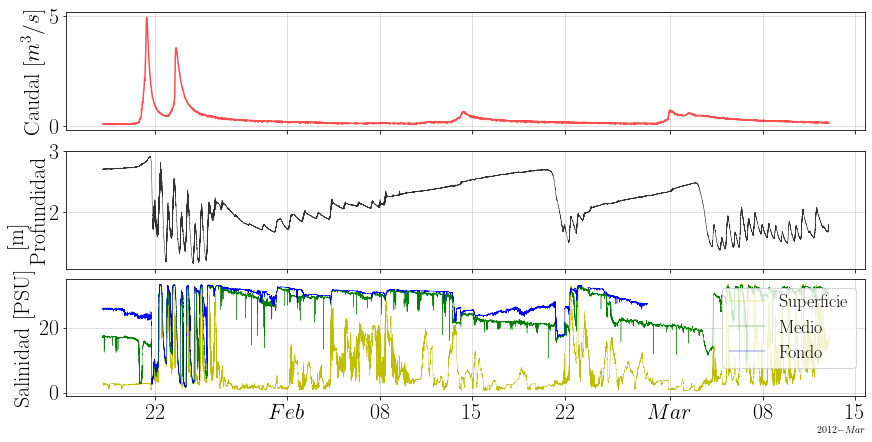

In [31]:
fig, (ax4, ax1, ax7) = plt.subplots(nrows=3, figsize=(12, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Grafico caudal
ax4.plot(Qdf.index, Qdf['10s'].values/35.315 , c='r', alpha=0.7);
ax4.set_ylabel(r"Caudal $[m^3/s]$",
          fontsize=22)
ax4.grid(alpha=0.5)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)

#Grafico de profundidad y densidad (color map) DC
ax1.set_ylabel(r"[m]\\"
          r"Profundidad",
          fontsize=22)
ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
# ax1.plot(dc1.index, dc2['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
# ax1.plot(dc1.index, dc3['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
# ax1.plot(dc1.index, dc4['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)

#Salinidad
ax7.set_ylabel(r"Salinidad [PSU]",
          fontsize=22)
ax7.plot(dc4.index, dc4['Salinity'], linewidth=0.4, c="y", label='Superficie')
# ax7.plot(dc3.index, dc3['Salinity'], linewidth=0.4, c="y", label='0.5 m')
ax7.plot(dc2.index, dc2['Salinity'], linewidth=0.4, c="g", label='Medio')
ax7.plot(dc1.index, dc1['Salinity'], linewidth=0.4, c="b", label='Fondo')

ax7.legend(loc='upper right',
          fontsize=18);
ax7.xaxis.set_tick_params(labelsize=22)
ax7.yaxis.set_tick_params(labelsize=22)
ax7.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

In [38]:
dc1

Depth   Salinity  Temperature     densidad
Datetime                                                          
2012-01-18 00:00:00  2.704110  25.700544    15.361001  1018.666480
2012-01-18 00:00:10  2.704024  25.691202    15.360693  1018.659407
2012-01-18 00:00:20  2.704124  25.694438    15.360495  1018.661921
2012-01-18 00:00:30  2.704024  25.689463    15.360539  1018.658111
2012-01-18 00:00:40  2.704067  25.680254    15.360415  1018.651101
...                       ...        ...          ...          ...
2012-03-20 23:59:20  1.808214  26.849567    11.048847  1020.342677
2012-03-20 23:59:30  1.816153  26.026005    11.037001  1019.708218
2012-03-20 23:59:40  1.814813  24.725940    11.020977  1018.706400
2012-03-20 23:59:50  1.810100  24.303529    11.017228  1018.380703
2012-03-21 00:00:00  1.803110  26.002492    11.026235  1019.691731

[544321 rows x 4 columns]

## Tiempo estudiado

In [30]:
bu2 = UV_burst.sel(time=slice("2012-02-11","2012-03-04")).u
wdf = dfw['u'].loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]
sf = snfco.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]
mt = mnty.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]
hm = hmoon.loc[datetime.date(2012,2,11):datetime.date(2012,3,5)]
Qdf = Q.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]
dc1 = DC_1.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]
dc2 = DC_2.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]
dc3 = DC_3.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]
dc4 = DC_4.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]

nm1 = NM_1.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]
nm2 = NM_2.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]
nm3 = NM_3.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]

ml1 = ML_1.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]
ml2 = ML_2.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]

pc1 = PC_1.loc[datetime.date(2012,2,11):datetime.date(2012,3,4)]

y_bin = np.linspace(0.91, 3.31, 25)

In [29]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

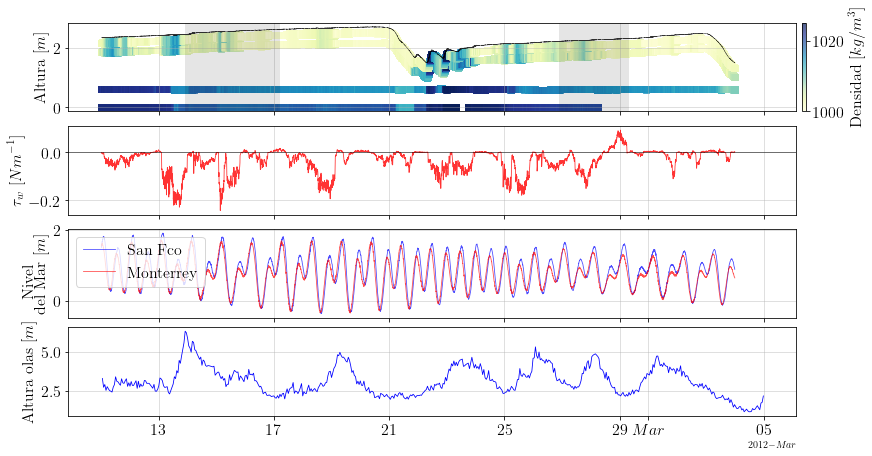

In [30]:
fig, (ax1, ax3, ax2, ax4) = plt.subplots(nrows=4, figsize=(12, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Grafico de profundidad y densidad (color map) DC
# ax1.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax1.set_ylabel(r"Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax1.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
scat = ax1.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc2.index, dc1.loc[dc2.index]['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc3.index, dc1.loc[dc3.index]['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc4.index, dc1.loc[dc4.index]['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax1, pad=0.007)
cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
cbar2.ax.tick_params(labelsize=16)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)


ax2.plot(sf.index, sf.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
ax2.plot(mt.index, mt.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
ax2.legend(loc='upper left',
          fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
#           fontsize=16)

ax4.set_ylabel(r"Altura olas "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

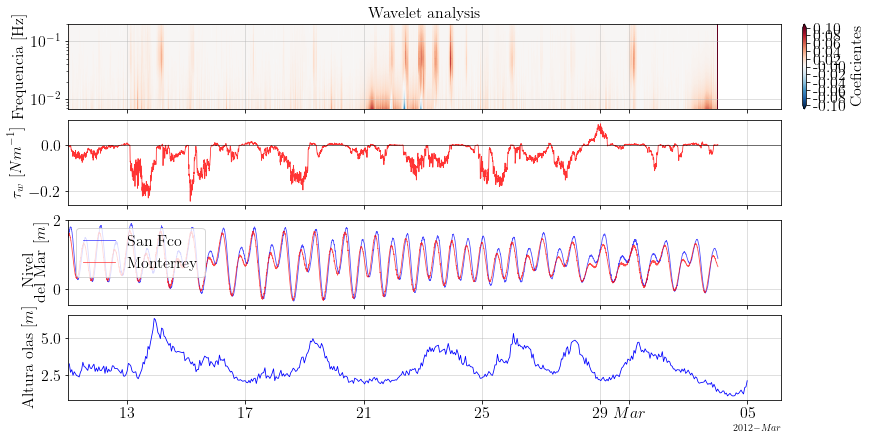

In [68]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

fig, (ax1, ax3, ax2, ax4) = plt.subplots(nrows=4, figsize=(12, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Wavelet
ax1.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax1.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax1.set_ylabel(r"Frequencia [Hz] ",
          fontsize=16)
ax1.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_yscale("log")



ax2.plot(sf.index, sf.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
ax2.plot(mt.index, mt.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
ax2.legend(loc='upper left',
          fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
#           fontsize=16)

ax4.set_ylabel(r"Altura olas "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

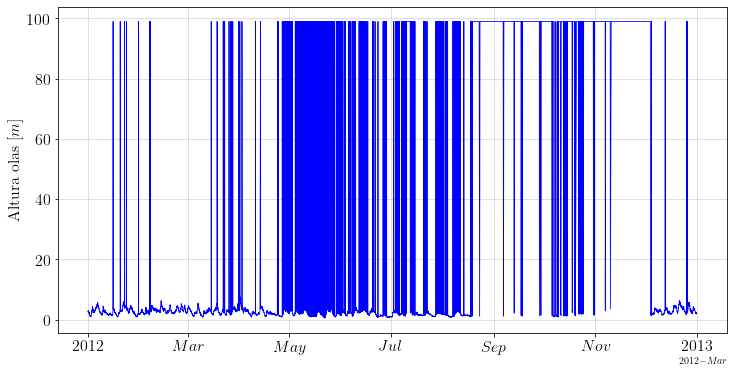

In [59]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(12, 6))

ax1.set_ylabel(r"Altura olas "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.plot(hmoon.index, hmoon['WVHT'].values, c='b', linewidth=0.8)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

## First breach

In [32]:
bu2 = UV_burst.sel(time=slice("2012-02-11","2012-02-21")).u
wdf = dfw['u'].loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
sf = snfco.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
mt = mnty.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
hm = hmoon.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
Qdf = Q.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
dc1 = DC_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
dc2 = DC_2.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
dc3 = DC_3.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
dc4 = DC_4.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]

nm1 = NM_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
nm2 = NM_2.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
nm3 = NM_3.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]

ml1 = ML_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]
ml2 = ML_2.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]

pc1 = PC_1.loc[datetime.date(2012,2,11):datetime.date(2012,2,21)]

y_bin = np.linspace(0.91, 3.31, 25)

In [33]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

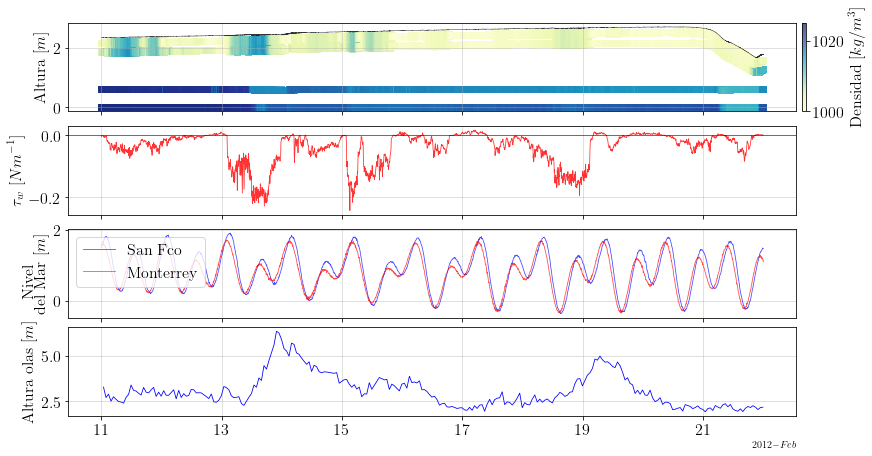

In [34]:
fig, (ax1, ax3, ax2, ax4) = plt.subplots(nrows=4, figsize=(12, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Grafico de profundidad y densidad (color map) DC
# ax1.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax1.set_ylabel(r"Altura "
          r"$\displaystyle[m]$",
          fontsize=16)

ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
scat = ax1.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc2.index, dc1.loc[dc2.index]['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc3.index, dc1.loc[dc3.index]['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc4.index, dc1.loc[dc4.index]['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax1, pad=0.007)
cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
cbar2.ax.tick_params(labelsize=16)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)


ax2.plot(sf.index, sf.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
ax2.plot(mt.index, mt.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
ax2.legend(loc='upper left',
          fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
#           fontsize=16)

ax4.set_ylabel(r"Altura olas "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

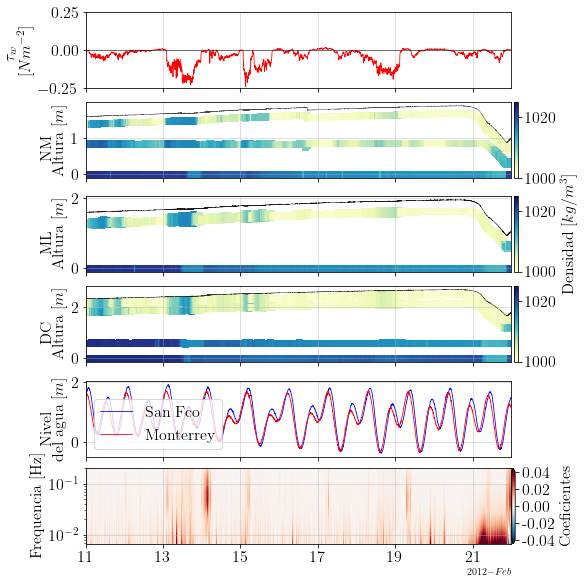

In [48]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax4, ax5, ax3, ax7, ax8) = plt.subplots(nrows=6, figsize=(8, 8), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
# contourf_ = ax1.contourf(bu2.time, y_bin,
#                          np.transpose(bu2.values),
#                          levels=level_boundaries_u,
#                          cmap=cm.RdBu_r,
#                          vmax=umax, vmin=umin, extend='both')
# cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
# cbar.ax.tick_params(labelsize=16)
# cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
# cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
# cbar.set_label("Velocity [$m/s$]", loc='center',
#           fontsize=16)
# ax1.set_ylabel(r"Depth "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax1.grid(alpha=0.5)
# ax1.set_ylim(1, 2.5)
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.yaxis.set_tick_params(labelsize=16)



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=16)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.7, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=16)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w$\\$[Nm^{-2}]$ ",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.25, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Altura $[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.9, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=16)
cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)



# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
ax7.set_ylabel(r"Nivel \\ del agua "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
ax7.legend(["San Fco", "Monterrey"], loc='lower left',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.001)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequencia [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

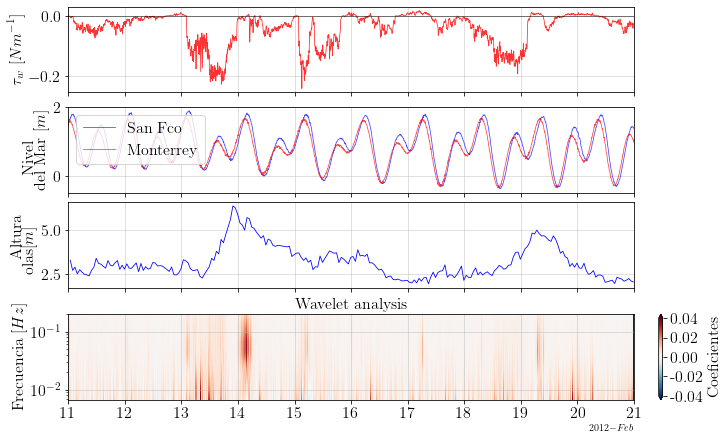

In [34]:
#Ajustar limites colorbar
umin = -0.04
umax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)

fig, (ax3, ax2, ax4, ax1) = plt.subplots(nrows=4, figsize=(10, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Wavelet
ax1.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax1.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
# ax1.set_ylabel(r'Frequencia [Hz]',
#           fontsize=16)
ax1.set_ylabel(r"Frecuencia "
          r"$\displaystyle[Hz]$",
          fontsize=16)
ax1.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_yscale("log")



ax2.plot(sf.index, sf.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
ax2.plot(mt.index, mt.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
ax2.legend(loc='upper left',
          fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
#           fontsize=16)

ax4.set_ylabel(r"Altura\\olas"
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

In [34]:
bu2 = UV_burst.sel(time=slice("2012-02-19 06:00:00","2012-02-19 12:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,19,6,0,0):datetime.datetime(2012,2,19,12,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,19,6,0,0):datetime.datetime(2012,2,19,12,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,19,6,0,0):datetime.datetime(2012,2,19,12,0,0)]
hm = hmoon.loc[datetime.datetime(2012,2,19,6,0,0):datetime.datetime(2012,2,19,12,0,0)]
Qdf = Q.loc[datetime.datetime(2012,2,19,6,0,0):datetime.datetime(2012,2,19,12,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,19,6,0,0):datetime.datetime(2012,2,19,12,0,0)]

y_bin = np.linspace(0.91, 3.31, 25)

In [42]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,701)
# widths = np.arange(1,41)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

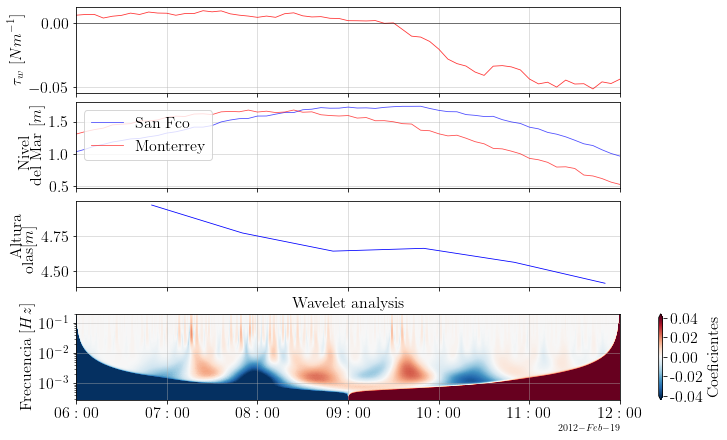

In [43]:
#Ajustar limites colorbar
umin = -0.04
umax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)

fig, (ax3, ax2, ax4, ax1) = plt.subplots(nrows=4, figsize=(10, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Wavelet
ax1.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax1.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
# ax1.set_ylabel(r'Frequencia [Hz]',
#           fontsize=16)
ax1.set_ylabel(r"Frecuencia "
          r"$\displaystyle[Hz]$",
          fontsize=16)
ax1.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_yscale("log")



ax2.plot(sf.index, sf.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
ax2.plot(mt.index, mt.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
ax2.legend(loc='upper left',
          fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
#           fontsize=16)

ax4.set_ylabel(r"Altura\\olas"
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

In [39]:
hm.loc[datetime.date(2012,2,14):datetime.datetime(2012,2,14,6,0,0)]

Empty DataFrame
Columns: [WVHT, TIDE]
Index: []

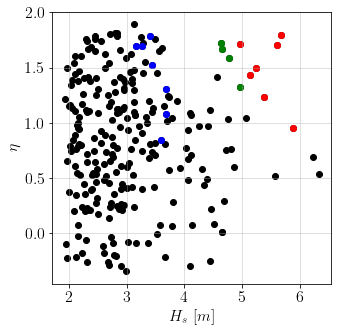

In [102]:
hm.index = hm.index + datetime.timedelta(minutes=10)
fig, (ax1) = plt.subplots(nrows= 1, figsize=(5, 5))

ax1.scatter(hm['WVHT'].values, sf.loc[hm.index].values, c="k")
ax1.scatter(hm['WVHT'].loc[datetime.date(2012,2,14):datetime.datetime(2012,2,14,6,0,0)].values, sf.loc[hm.index].loc[datetime.date(2012,2,14):datetime.datetime(2012,2,14,6,0,0)].values, c="r")
ax1.scatter(hm['WVHT'].loc[datetime.date(2012,2,15):datetime.datetime(2012,2,15,6,0,0)].values, sf.loc[hm.index].loc[datetime.date(2012,2,15):datetime.datetime(2012,2,15,6,0,0)].values, c="b")
ax1.scatter(hm['WVHT'].loc[datetime.datetime(2012,2,19,7,0,0):datetime.datetime(2012,2,19,10,0,0)].values, sf.loc[hm.index].loc[datetime.datetime(2012,2,19,7,0,0):datetime.datetime(2012,2,19,10,0,0)].values, c="g")
ax1.set_ylabel("$\eta$ ",
          fontsize=16)
ax1.set_xlabel("$H_s$ "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)


# Second breach

In [31]:
bu2 = UV_burst.sel(time=slice("2012-02-24","2012-03-04")).u
wdf = dfw['u'].loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]
sf = snfco.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]
mt = mnty.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]
hm = hmoon.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]
dc1 = DC_1.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]
dc2 = DC_2.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]
dc3 = DC_3.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]
dc4 = DC_4.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]

nm1 = NM_1.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]
nm2 = NM_2.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]
nm3 = NM_3.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]

ml1 = ML_1.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]
ml2 = ML_2.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]

pc1 = PC_1.loc[datetime.date(2012,2,24):datetime.date(2012,3,4)]

y_bin = np.linspace(0.91, 3.31, 25)

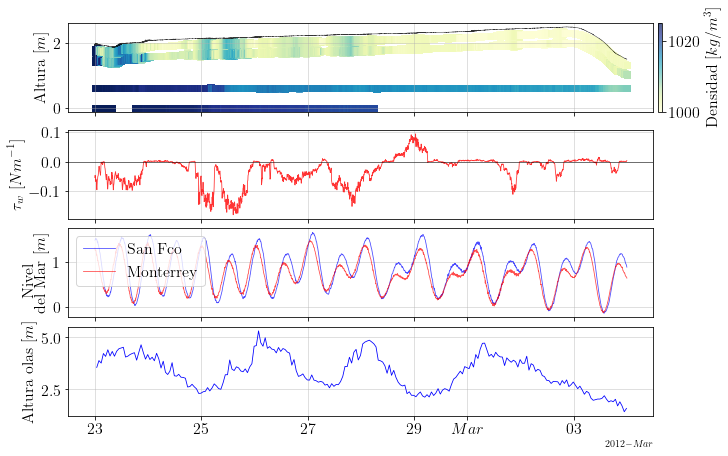

In [53]:
fig, (ax1, ax3, ax2, ax4) = plt.subplots(nrows=4, figsize=(10, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Grafico de profundidad y densidad (color map) DC
# ax1.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax1.set_ylabel(r"Altura "
          r"$\displaystyle[m]$",
          fontsize=16)

ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
scat = ax1.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc2.index, dc1.loc[dc2.index]['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc3.index, dc1.loc[dc3.index]['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc4.index, dc1.loc[dc4.index]['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax1, pad=0.007)
cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
cbar2.ax.tick_params(labelsize=16)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)


ax2.plot(sf.index, sf.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
ax2.plot(mt.index, mt.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
ax2.legend(loc='upper left',
          fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
#           fontsize=16)

ax4.set_ylabel(r"Altura olas "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

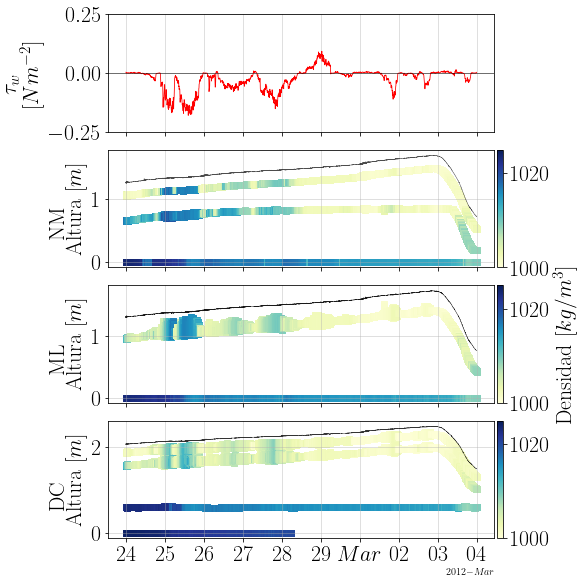

In [32]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax4, ax5, ax3) = plt.subplots(nrows=4, figsize=(8, 8), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
# contourf_ = ax1.contourf(bu2.time, y_bin,
#                          np.transpose(bu2.values),
#                          levels=level_boundaries_u,
#                          cmap=cm.RdBu_r,
#                          vmax=umax, vmin=umin, extend='both')
# cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
# cbar.ax.tick_params(labelsize=16)
# cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
# cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
# cbar.set_label("Velocity [$m/s$]", loc='center',
#           fontsize=16)
# ax1.set_ylabel(r"Depth "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax1.grid(alpha=0.5)
# ax1.set_ylim(1, 2.5)
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.yaxis.set_tick_params(labelsize=16)



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.7, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=22)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w$\\$[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.25, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Altura $[m]$",
          fontsize=22)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.9, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=22)
cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=22)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)


#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

In [36]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
# widths = np.arange(1,201)
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

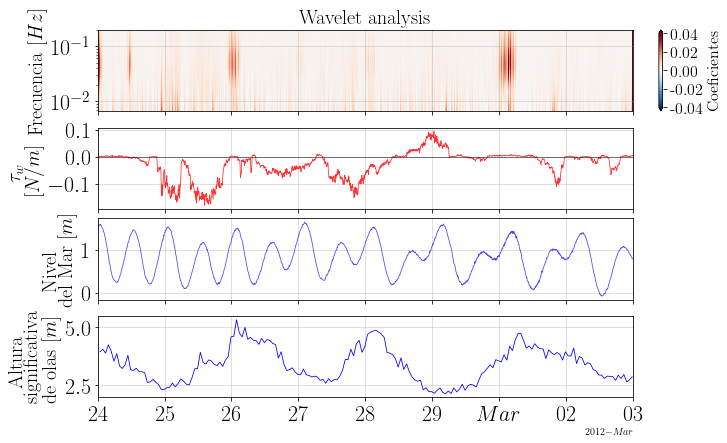

In [41]:
#Ajustar limites colorbar
umin = -0.04
umax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)

fig, (ax1, ax3, ax2, ax4) = plt.subplots(nrows=4, figsize=(10, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Wavelet
ax1.set_title(r"Wavelet analysis",
          fontsize=20)
contourf_ = ax1.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
# ax1.set_ylabel(r'Frequencia [Hz]',
#           fontsize=16)
ax1.set_ylabel(r"Frecuencia "
          r"$\displaystyle[Hz]$",
          fontsize=20)
ax1.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.set_yscale("log")



ax2.plot(sf.index, sf.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
# ax2.plot(mt.index, mt.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
# ax2.legend(loc='upper left',
#           fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=20)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)

ax3.set_ylabel(r"$\tau_w$\\"
          r"$\displaystyle[N/m]$",
          fontsize=20)
ax3.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
#           fontsize=16)

ax4.set_ylabel(r"Altura\\significativa\\de olas "
          r"$\displaystyle[m]$",
          fontsize=20)
ax4.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

In [131]:
bu2 = UV_burst.sel(time=slice("2012-02-29 12:00:00","2012-03-01 12:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,29,12,0,0):datetime.datetime(2012,3,1,12,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,29,12,0,0):datetime.datetime(2012,3,1,12,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,29,12,0,0):datetime.datetime(2012,3,1,12,0,0)]
hm = hmoon.loc[datetime.datetime(2012,2,29,12,0,0):datetime.datetime(2012,3,1,12,0,0)]
Qdf = Q.loc[datetime.datetime(2012,2,29,12,0,0):datetime.datetime(2012,3,1,12,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,29,12,0,0):datetime.datetime(2012,3,1,12,0,0)]

y_bin = np.linspace(0.91, 3.31, 25)

In [132]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
# widths = np.arange(1,201)
widths = np.arange(1,41)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

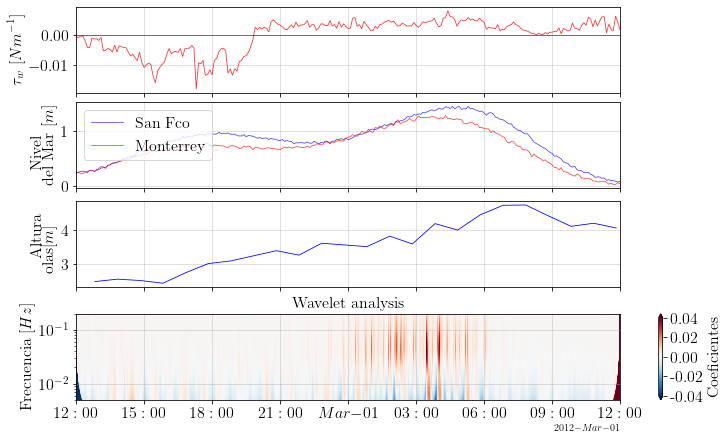

In [133]:
#Ajustar limites colorbar
umin = -0.04
umax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)

fig, (ax3, ax2, ax4, ax1) = plt.subplots(nrows=4, figsize=(10, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Wavelet
ax1.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax1.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
# ax1.set_ylabel(r'Frequencia [Hz]',
#           fontsize=16)
ax1.set_ylabel(r"Frecuencia "
          r"$\displaystyle[Hz]$",
          fontsize=16)
ax1.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_yscale("log")



ax2.plot(sf.index, sf.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
ax2.plot(mt.index, mt.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
ax2.legend(loc='upper left',
          fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
#           fontsize=16)

ax4.set_ylabel(r"Altura\\olas"
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

In [77]:
hm.loc[datetime.date(2012,2,14):datetime.datetime(2012,2,14,6,0,0)]

WVHT TIDE
index                         
2012-02-14 00:50:00  5.38   99
2012-02-14 01:50:00  5.25   99
2012-02-14 02:50:00  4.97   99
2012-02-14 03:50:00  5.68   99
2012-02-14 04:50:00  5.61   99
2012-02-14 05:50:00  5.14   99

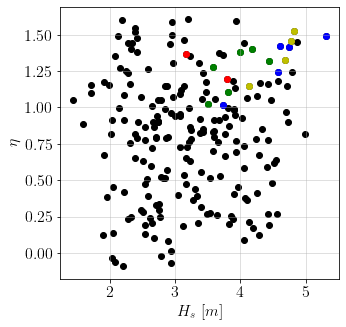

In [135]:
hm.index = hm.index + datetime.timedelta(minutes=10)
fig, (ax1) = plt.subplots(nrows= 1, figsize=(5, 5))

ax1.scatter(hm['WVHT'].values, sf.loc[hm.index].values, c="k")
ax1.scatter(hm['WVHT'].loc[datetime.datetime(2012,2,24,10,30,0):datetime.datetime(2012,2,24,12,0,0)].values, sf.loc[hm.index].loc[datetime.datetime(2012,2,24,10,30,0):datetime.datetime(2012,2,24,12,0,0)].values, c="r")
ax1.scatter(hm['WVHT'].loc[datetime.datetime(2012,2,25,23,0,0):datetime.datetime(2012,2,26,3,0,0)].values, sf.loc[hm.index].loc[datetime.datetime(2012,2,25,23,0,0):datetime.datetime(2012,2,26,3,0,0)].values, c="b")
ax1.scatter(hm['WVHT'].loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,28,3,0,0)].values, sf.loc[hm.index].loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,28,3,0,0)].values, c="y")
ax1.scatter(hm['WVHT'].loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,1,6,0,0)].values, sf.loc[hm.index].loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,1,6,0,0)].values, c="g")
ax1.set_ylabel("$\eta$ ",
          fontsize=16)
ax1.set_xlabel("$H_s$ "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)


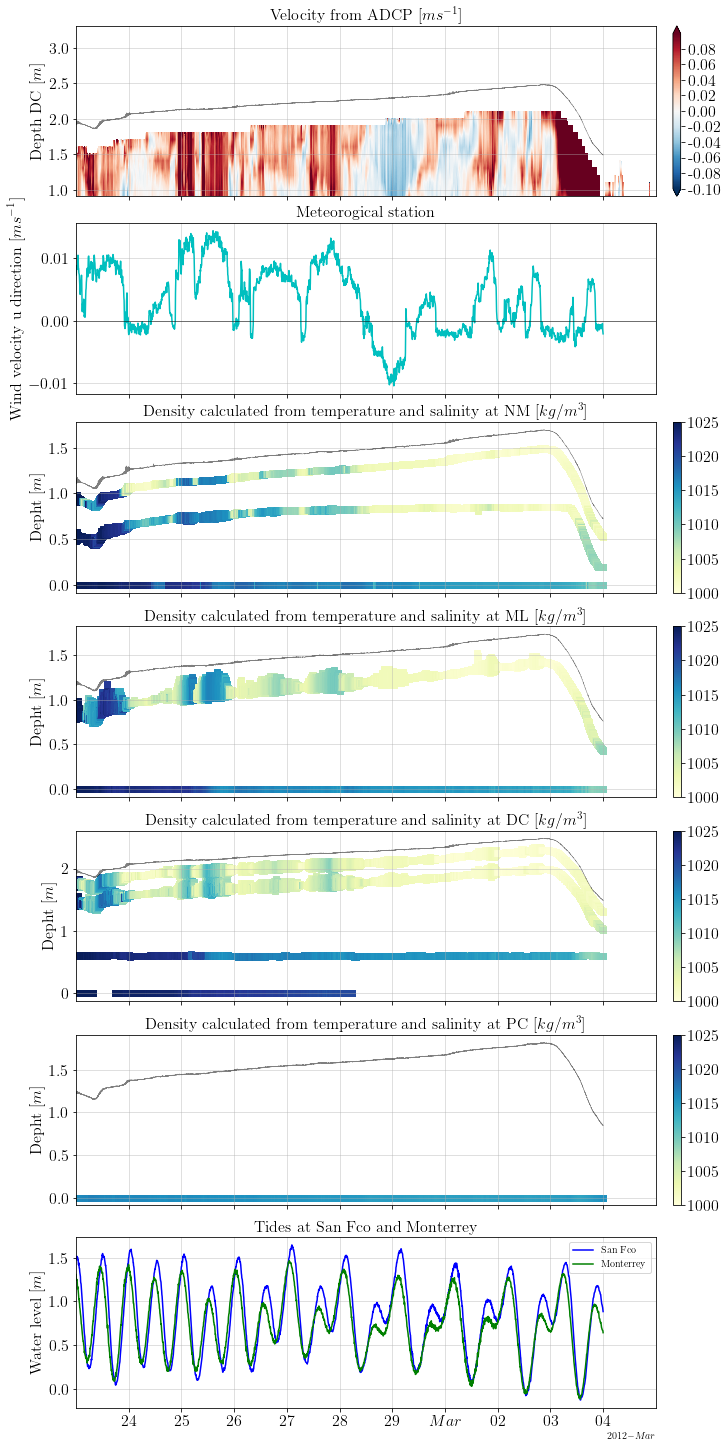

In [28]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7) = plt.subplots(nrows=7, figsize=(10, 20), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico densidades PC

ax6.set_title(r"Density calculated from temperature and salinity at PC [$kg/m^3$]",
          fontsize=16)
ax6.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(pc1.index, pc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax6.scatter(pc1.index, pc1['Depth'].values-pc1['Depth'].values, c=pc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar5 = fig.colorbar(scat, ax=ax6, pad=0.03)
cbar5.ax.tick_params(labelsize=16)
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right');
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

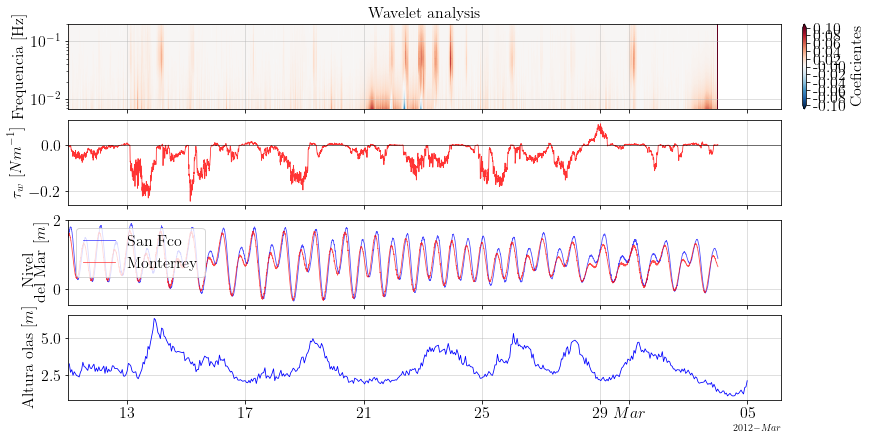

In [68]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

fig, (ax1, ax3, ax2, ax4) = plt.subplots(nrows=4, figsize=(12, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Wavelet
ax1.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax1.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax1.set_ylabel(r"Frequencia [Hz] ",
          fontsize=16)
ax1.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_yscale("log")



ax2.plot(sf.index, sf.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
ax2.plot(mt.index, mt.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
ax2.legend(loc='upper left',
          fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
#           fontsize=16)

ax4.set_ylabel(r"Altura olas "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(hm.index, hm['WVHT'].values, c='b', linewidth=0.8)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

## 23-Mar

In [25]:
bu2 = UV_burst.sel(time=slice("2012-02-23 00:00:00","2012-02-24 00:00:00")).u
wdf = dfw['u'].loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
sf = snfco.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
mt = mnty.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
dc1 = DC_1.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
dc2 = DC_2.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
dc3 = DC_3.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
dc4 = DC_4.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]

nm1 = NM_1.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
nm2 = NM_2.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
nm3 = NM_3.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]

ml1 = ML_1.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
ml2 = ML_2.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]

pc1 = PC_1.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]

In [26]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

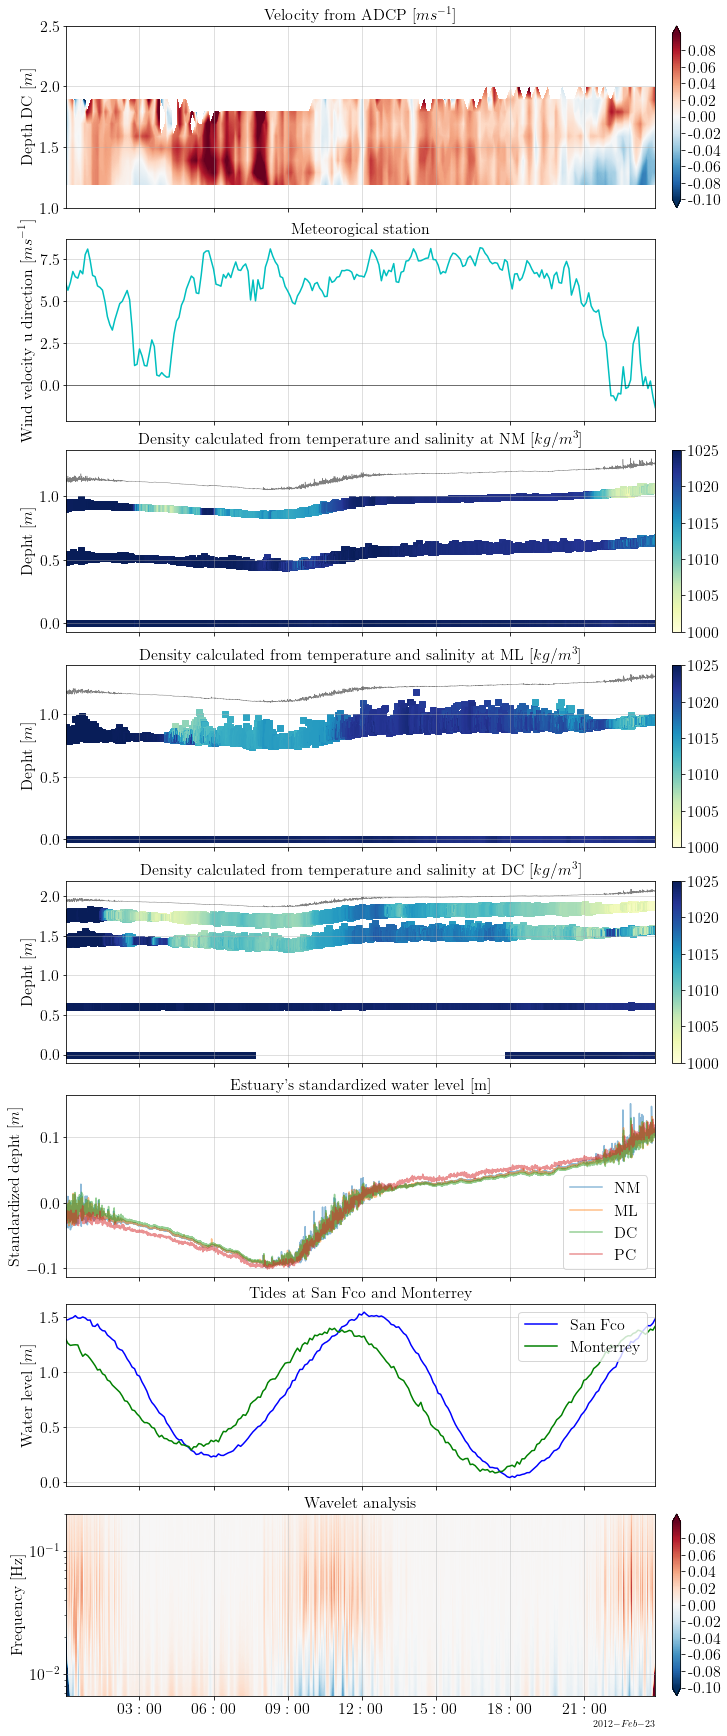

In [27]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 24), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada

ax6.set_title(r"Estuary's standardized water level [m]",
          fontsize=16)
ax6.set_ylabel(r"Standardized depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), alpha=0.5)
ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), alpha=0.5)
ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "ML", "DC", "PC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
ax8.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

- La boca comienza a cerrarse
- Se observa que existe wave overtopping cuando la marea aumenta, ya que la densidad en la superficie aumenta
- Marea domina le movimiento dentro del estuario
- Cuando baja la marea se observa que el estuario se estratifica y cuando sube vuelve a mezclarse

<ipython-input-31-2dcf91c340a2>:54: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


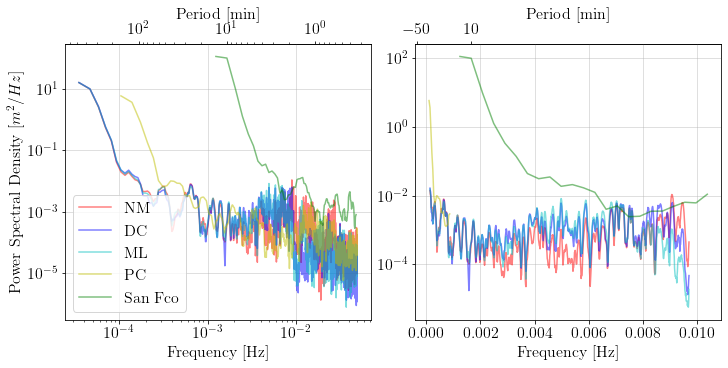

In [31]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='DC')
axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, label='ML')
axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, label='PC')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs4[sl], psd4[sl], 'c', 
              freqs5[sl4], psd5[sl4], 'y', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

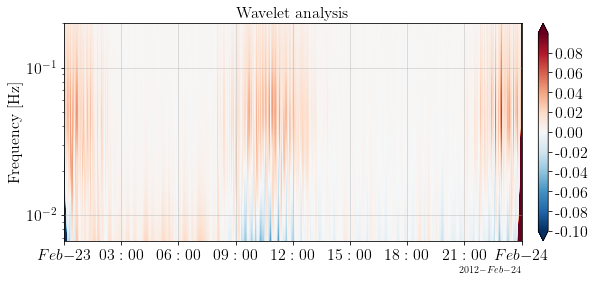

In [58]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1) = plt.subplots(nrows=1, figsize=(10, 4))


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax1.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax1.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_yscale("log")
# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

## 24-Mar

In [28]:
bu2 = UV_burst.sel(time=slice("2012-02-24 00:00:00","2012-02-25 00:00:00")).u
wdf = dfw['u'].loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]
sf = snfco.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]
mt = mnty.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]
dc1 = DC_1.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]
dc2 = DC_2.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]
dc3 = DC_3.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]
dc4 = DC_4.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]

nm1 = NM_1.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]
nm2 = NM_2.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]
nm3 = NM_3.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]

ml1 = ML_1.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]
ml2 = ML_2.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]

pc1 = PC_1.loc[datetime.date(2012,2,24):datetime.date(2012,2,25)]

In [29]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

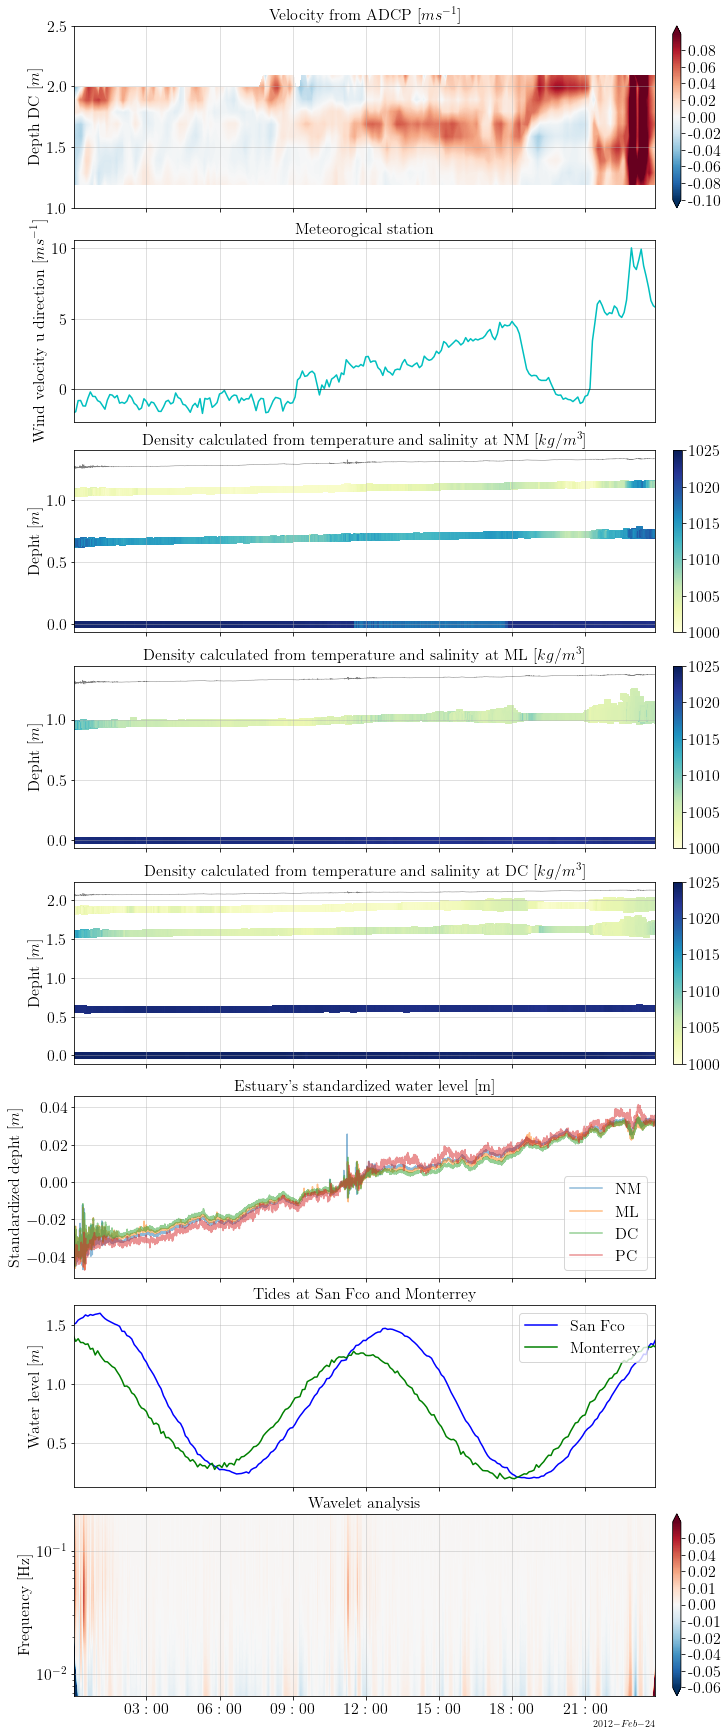

In [32]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 24), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada

ax6.set_title(r"Estuary's standardized water level [m]",
          fontsize=16)
ax6.set_ylabel(r"Standardized depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), alpha=0.5)
ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), alpha=0.5)
ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "ML", "DC", "PC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.06
umax = 0.06
vmin = -0.06
vmax = 0.06
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
ax8.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

- La boca comienza a cerrarse
- Se observa que existe wave overtopping cuando la marea aumenta, ya que la superficie se vuelve más irregular en ese momento, pero la densidad en la superficie no aumenta. Esto último podría indicar que el agua que pasó la barrera era poca.
- Marea no domina el movimiento dentro del estuario
- El estuario se mantiene estratificado a lo largo de este periodo
- Se observa un evento de viento fuerte al final del día, cerca de las 00, donde podría existir un evento de upwelling debido a que la densidad aumenta en NM y disminuye en DC.

<ipython-input-77-2dcf91c340a2>:54: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


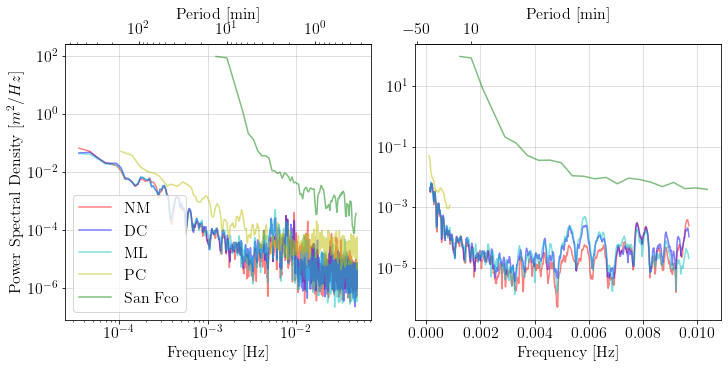

In [77]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='DC')
axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, label='ML')
axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, label='PC')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs4[sl], psd4[sl], 'c', 
              freqs5[sl4], psd5[sl4], 'y', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

## 25-Mar y un poco antes

In [55]:
bu2 = UV_burst.sel(time=slice("2012-02-25 01:30:00","2012-02-25 07:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)]

delta = Delta_nmdc.loc[datetime.datetime(2012,2,25,1,30,0):datetime.datetime(2012,2,25,7,0,0)] 

In [39]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

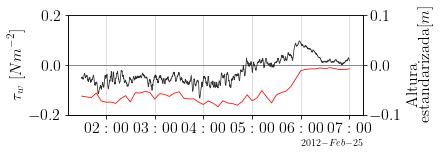

In [56]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2) = plt.subplots(nrows=1, figsize=(6, 2), constrained_layout=True, sharex=True)

ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.2, 0.2)

ax6 = ax2.twinx()

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Altura\\estandarizada$[m]$",
          fontsize=16)
# ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
# ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
ax6.plot(delta.index, delta.values*10-0.03, linewidth=0.8, c="k", alpha=0.8)
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
# ax6.legend(["NM", "DC", "NM-DC"], loc='lower right',
#           fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)
ax6.set_ylim(-0.1, 0.1)
# Ajustar formato fecha


ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)


plt.show() 

In [43]:
bu2 = UV_burst.sel(time=slice("2012-02-24 00:00:00","2012-02-26 21:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)]

delta = Delta_nmdc.loc[datetime.datetime(2012,2,24,0,0,0):datetime.datetime(2012,2,26,21,0,0)] 

In [47]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

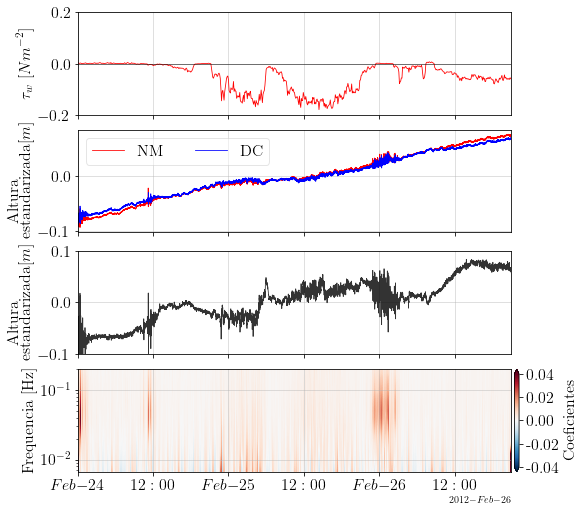

In [49]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax6, ax7, ax8) = plt.subplots(nrows=4, figsize=(8, 7), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
# contourf_ = ax1.contourf(bu2.time, y_bin,
#                          np.transpose(bu2.values),
#                          levels=level_boundaries_u,
#                          cmap=cm.RdBu_r,
#                          vmax=umax, vmin=umin, extend='both')
# cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
# cbar.ax.tick_params(labelsize=16)
# cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
# cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
# cbar.set_label("Velocidad [$m/s$]", loc='center',
#           fontsize=16)
# ax1.set_ylabel(r"Altura "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax1.grid(alpha=0.5)
# ax1.set_ylim(0.7, 2.5)
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.yaxis.set_tick_params(labelsize=16)
# ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.2, 0.2)



# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Altura\\estandarizada$[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='upper left', ncol=2,framealpha=0.5,
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

ax7.set_ylabel(r"Altura\\estandarizada$[m]$",
          fontsize=16)

ax7.plot(delta.index, delta.values*10-0.03, linewidth=0.8, c="k", alpha=0.8)
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)

ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)
ax7.set_ylim(-0.1, 0.1)

# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
# ax7.set_ylabel(r"Nivel\\del agua "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
# ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
# ax7.legend(["San Fco", "Monterrey"], loc='lower left',
#           fontsize=16);
# ax7.xaxis.set_tick_params(labelsize=16)
# ax7.yaxis.set_tick_params(labelsize=16)
# ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequencia [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha


ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)


plt.show() 

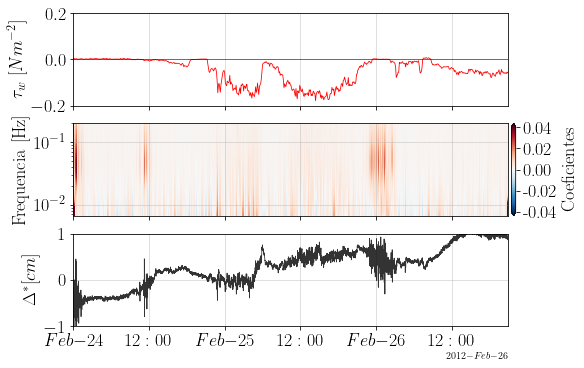

In [56]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax8, ax7) = plt.subplots(nrows=3, figsize=(8, 5), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
# contourf_ = ax1.contourf(bu2.time, y_bin,
#                          np.transpose(bu2.values),
#                          levels=level_boundaries_u,
#                          cmap=cm.RdBu_r,
#                          vmax=umax, vmin=umin, extend='both')
# cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
# cbar.ax.tick_params(labelsize=16)
# cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
# cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
# cbar.set_label("Velocidad [$m/s$]", loc='center',
#           fontsize=16)
# ax1.set_ylabel(r"Altura "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax1.grid(alpha=0.5)
# ax1.set_ylim(0.7, 2.5)
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.yaxis.set_tick_params(labelsize=16)
# ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=18)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.2, 0.2)

ax7.set_ylabel(r"$\Delta^* [cm]$",
          fontsize=18)

ax7.plot(delta.index, delta.values*100-0.03, linewidth=0.8, c="k", alpha=0.8)
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)

ax7.xaxis.set_tick_params(labelsize=18)
ax7.yaxis.set_tick_params(labelsize=18)
ax7.grid(alpha=0.5)
ax7.set_ylim(-1, 1)

# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
# ax7.set_ylabel(r"Nivel\\del agua "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
# ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
# ax7.legend(["San Fco", "Monterrey"], loc='lower left',
#           fontsize=16);
# ax7.xaxis.set_tick_params(labelsize=16)
# ax7.yaxis.set_tick_params(labelsize=16)
# ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=18)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=18)
ax8.set_ylabel(r"Frequencia [Hz] ",
          fontsize=18)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=18)
ax8.yaxis.set_tick_params(labelsize=18)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha


ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)


plt.show() 

In [47]:
bu2 = UV_burst.sel(time=slice("2012-02-25 22:00:00","2012-02-26 04:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]

delta = Delta_nmdc.loc[datetime.datetime(2012,2,25,22,0,0):datetime.datetime(2012,2,26,4,0,0)]

In [48]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,301)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

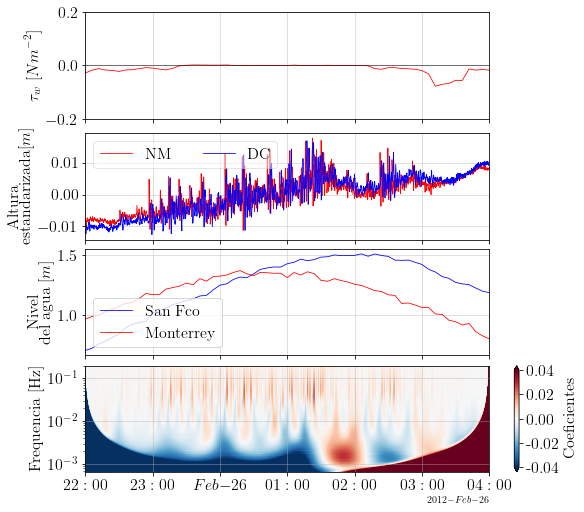

In [53]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax6, ax7, ax8) = plt.subplots(nrows=4, figsize=(8, 7), constrained_layout=True, sharex=True)



#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.2, 0.2)



# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Altura\\estandarizada$[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
# ax6.plot(delta.index, delta.values*10-0.03, linewidth=0.8, c="k", alpha=0.8)
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='upper left', ncol=2,framealpha=0.5,
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)
# ax6.set_ylim(-0.1, 0.1)

# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
ax7.set_ylabel(r"Nivel\\del agua "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
ax7.legend(["San Fco", "Monterrey"], loc='lower left',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequencia [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha


ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)


plt.show() 

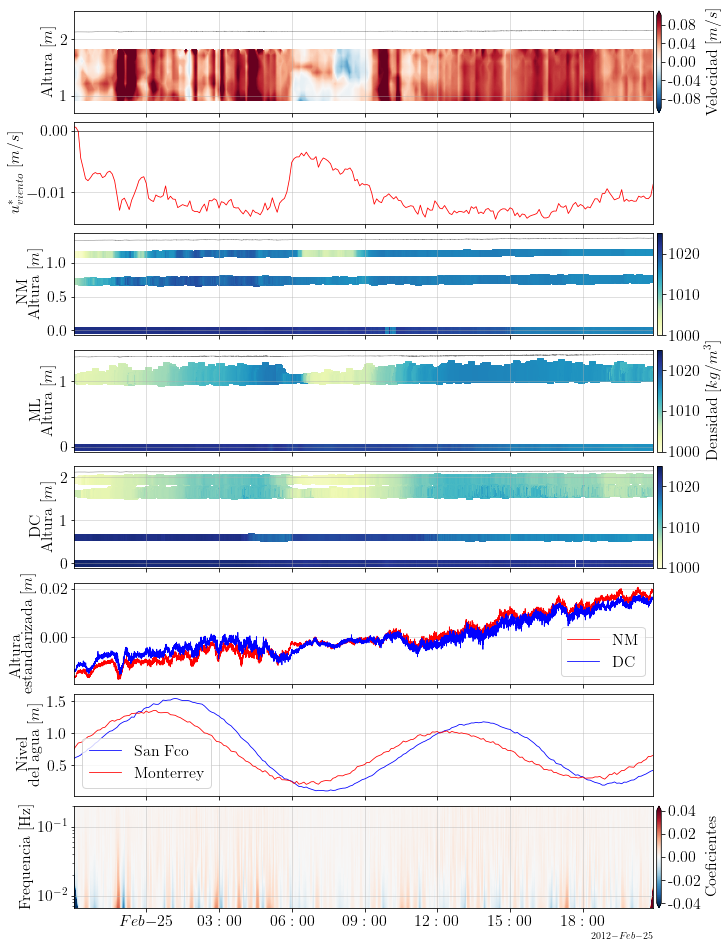

In [50]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 13), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
cbar.set_label("Velocidad [$m/s$]", loc='center',
          fontsize=16)
ax1.set_ylabel(r"Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(0.7, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$u^*_{viento}$ "
          r"$\displaystyle[m/s]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC\\Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=16)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM\\Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=16)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML\\Altura $[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=16)
cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Altura\\estandarizada "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
ax7.set_ylabel(r"Nivel\\del agua "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
ax7.legend(["San Fco", "Monterrey"], loc='lower left',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequencia [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

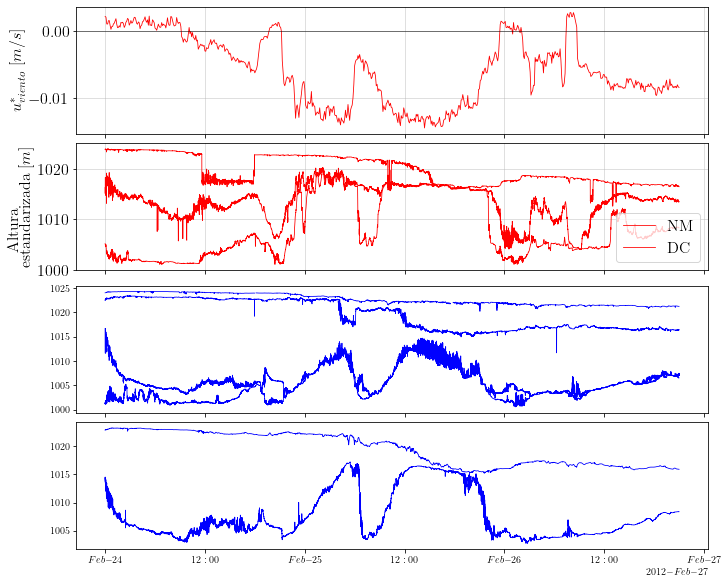

In [39]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax6, ax7, ax8) = plt.subplots(nrows=4, figsize=(10, 8), constrained_layout=True, sharex=True)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$u^*_{viento}$ "
          r"$\displaystyle[m/s]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Altura\\estandarizada "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['densidad'], linewidth=0.8, c="r")
ax6.plot(nm2.index, nm2['densidad'], linewidth=0.8, c="r")
ax6.plot(nm3.index, nm3['densidad'], linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax7.plot(dc1.index, dc1['densidad'], linewidth=0.8, c="b")
ax7.plot(dc2.index, dc2['densidad'], linewidth=0.8, c="b")
ax7.plot(dc3.index, dc3['densidad'], linewidth=0.8, c="b")
ax7.plot(dc4.index, dc4['densidad'], linewidth=0.8, c="b")

ax8.plot(ml1.index, ml1['densidad'], linewidth=0.8, c="b")
ax8.plot(ml2.index, ml2['densidad'], linewidth=0.8, c="b")

# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

- La boca está completamente cerrada
- No se observa wave overtopping pero se debe comprobar
- Viento domina le movimiento dentro del estuario
- Evento de viento fuerte podría estar provocando un upwelling ya que existe un aumento en la densidad de la superficie, comenzando por NM y paulativamente llendo hacia ML y luego DC.
- Al momento que la velocidad del viento disminuye, se observa que la densidad de la superficie disminuye, representando que está volviendo al equlibrio de estuario estratificado. En las velocidades se observa como la capa inferior retrocede volviendo a su posición original.
- Luego de lo anterior, se observa en las velocidades que existe un cambio de dirección en ambos estratos.


In [29]:
bu2 = UV_burst.sel(time=slice("2012-02-24 21:00:00","2012-02-25 21:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]

delta = Delta_nmdc.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,21,0,0)]

<ipython-input-38-97ce5f4c39d2>:62: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


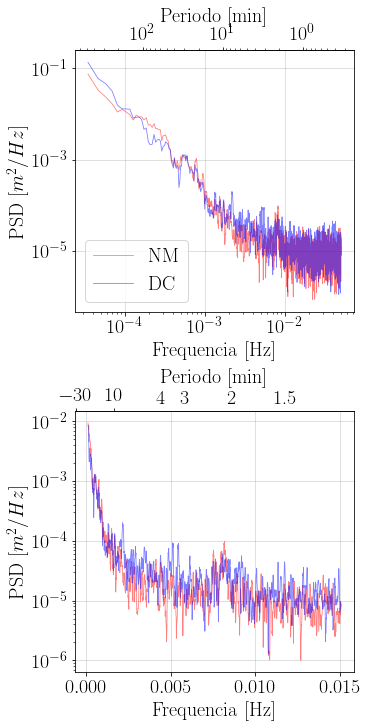

In [38]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(nrows=2, figsize=(5, 10), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, linewidth=0.8, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, linewidth=0.8, label='DC')
# axs[0].loglog(freqs3, psd3, 'c', alpha=0.5, linewidth=0.8, label='sf')
# axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, linewidth=0.8, label='ML')
# axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, linewidth=0.8, label='PC')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=20)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 1.50464135e-02])
i04, i14 = np.searchsorted(freqs5, [1.31969058e-04, 9.70464135e-03])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', alpha=0.5, linewidth=0.8)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('PSD [$m^2/Hz$]',
          fontsize=20)
axs[0].set_xlabel('Frequencia [Hz]',
          fontsize=20)
axs[1].set_ylabel('PSD [$m^2/Hz$]',
          fontsize=20)
axs[1].set_xlabel('Frequencia [Hz]',
          fontsize=20)
axs[0].xaxis.set_tick_params(labelsize=20)
axs[0].yaxis.set_tick_params(labelsize=20)
axs[1].xaxis.set_tick_params(labelsize=20)
axs[1].yaxis.set_tick_params(labelsize=20)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)
# axs[1].axvline(x=0.0092, color='k', linewidth=0.5, alpha=0.8)
# axs[1].axvline(x=0.008333, color='k', linewidth=50, alpha=0.1)
axs[1].text(0.008333, 0.02, '2',
          fontsize=20)
axs[1].text(0.005555, 0.02, '3',
          fontsize=20)
axs[1].text(0.004166, 0.02, '4',
          fontsize=20)
axs[1].text(0.011111, 0.02, '1.5',
          fontsize=20)

def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Periodo [min]',
          fontsize=20)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Periodo [min]',
          fontsize=20)
secax0.xaxis.set_tick_params(labelsize=20)
secax0.yaxis.set_tick_params(labelsize=20)
secax1.xaxis.set_tick_params(labelsize=20)
secax1.yaxis.set_tick_params(labelsize=20)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

In [33]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,301)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

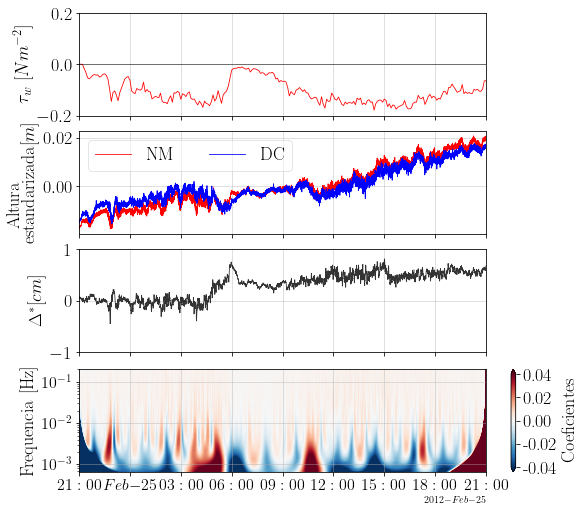

In [36]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax6, ax7, ax8) = plt.subplots(nrows=4, figsize=(8, 7), constrained_layout=True, sharex=True)



#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=18)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.2, 0.2)



# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Altura\\estandarizada$[m]$",
          fontsize=18)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
# ax6.plot(delta.index, delta.values*10-0.03, linewidth=0.8, c="k", alpha=0.8)
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='upper left', ncol=2,framealpha=0.5,
          fontsize=18);
ax6.xaxis.set_tick_params(labelsize=18)
ax6.yaxis.set_tick_params(labelsize=18)
ax6.grid(alpha=0.5)
# ax6.set_ylim(-0.1, 0.1)

# Grafico delta nivel del agua
ax7.plot(delta.index, delta.values*100-0.03, linewidth=0.8, c="k", alpha=0.8)
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax7.set_ylabel(r"$\Delta^* [cm]$",
          fontsize=18)
ax7.xaxis.set_tick_params(labelsize=18)
ax7.yaxis.set_tick_params(labelsize=18)
ax7.grid(alpha=0.5)
ax7.set_ylim(-1, 1)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=18)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=18)
ax8.set_ylabel(r"Frequencia [Hz] ",
          fontsize=18)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha


ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)


plt.show() 

<ipython-input-89-8530f9670b3c>:62: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


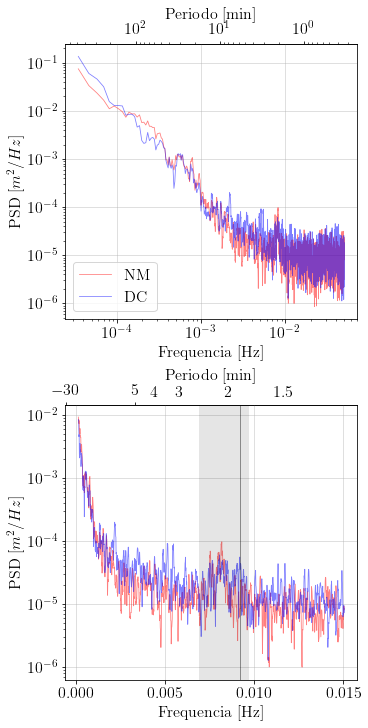

In [89]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, linewidth=0.8, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, linewidth=0.8, label='DC')
# axs[0].loglog(freqs3, psd3, 'c', alpha=0.5, linewidth=0.8, label='sf')
# axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, linewidth=0.8, label='ML')
# axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, linewidth=0.8, label='PC')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 1.50464135e-02])
i04, i14 = np.searchsorted(freqs5, [1.31969058e-04, 9.70464135e-03])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', alpha=0.5, linewidth=0.8)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('PSD [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequencia [Hz]',
          fontsize=16)
axs[1].set_ylabel('PSD [$m^2/Hz$]',
          fontsize=16)
axs[1].set_xlabel('Frequencia [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)
axs[1].axvline(x=0.0092, color='k', linewidth=0.5, alpha=0.8)
axs[1].axvline(x=0.008333, color='k', linewidth=50, alpha=0.1)
axs[1].text(0.008333, 0.02, '2',
          fontsize=16)
axs[1].text(0.005555, 0.02, '3',
          fontsize=16)
axs[1].text(0.004166, 0.02, '4',
          fontsize=16)
axs[1].text(0.011111, 0.02, '1.5',
          fontsize=16)

def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Periodo [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Periodo [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

In [75]:
dc1 = DC_1.loc[datetime.datetime(2012,2,25,5,0,0):datetime.datetime(2012,2,25,6,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,25,5,0,0):datetime.datetime(2012,2,25,6,0,0)]

#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

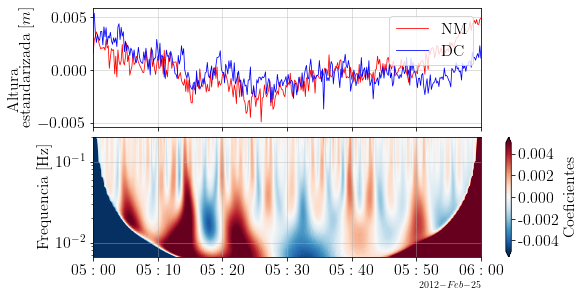

In [84]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax6, ax8) = plt.subplots(nrows=2, figsize=(8, 4), constrained_layout=True, sharex=True)

ax6.set_ylabel(r"Altura\\estandarizada "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='upper right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)
ax6.xaxis.set_major_locator(locator)
ax6.xaxis.set_major_formatter(formatter)

#Ajustar limites colorbar
umin = -0.005
umax = 0.005
vmin = -0.005
vmax = 0.005
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.002))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequencia [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

## 25-Mar y un poco antes
mayor analisis

In [68]:
bu2 = UV_burst.sel(time=slice("2012-02-24 21:00:00","2012-02-25 10:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,24,21,0,0):datetime.datetime(2012,2,25,10,0,0)]

In [69]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

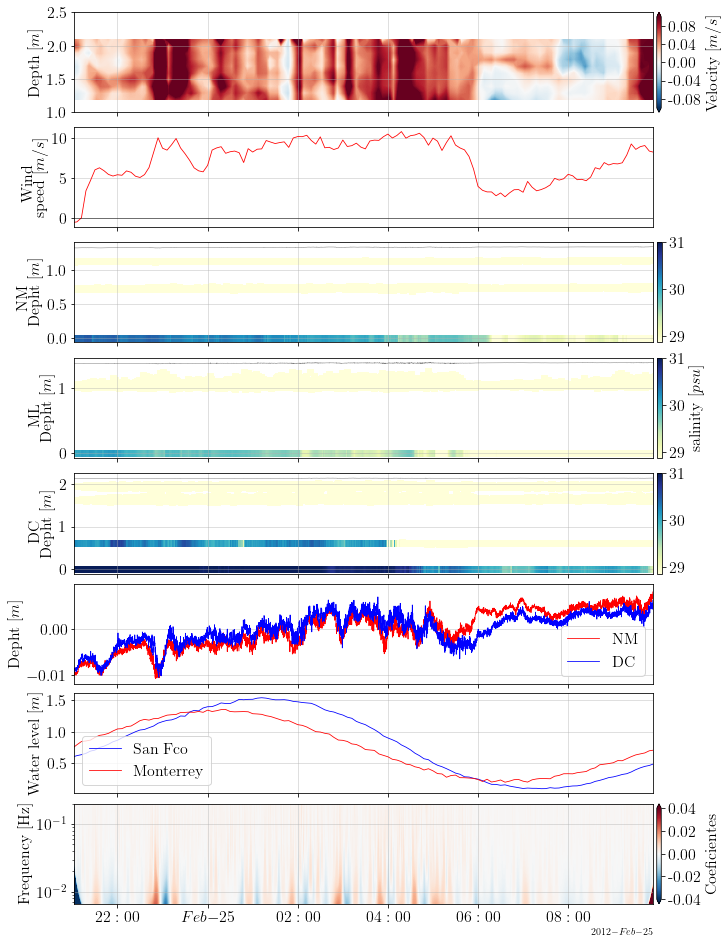

In [62]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 13), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
cbar.set_label("Velocity [$m/s$]", loc='center',
          fontsize=16)
ax1.set_ylabel(r"Depth "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"Wind \\ speed "
          r"$\displaystyle[m/s]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['Salinity'], marker='s', cmap=cm.YlGnBu, vmin=28.87, vmax=31)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['Salinity'], marker='s', cmap=cm.YlGnBu, vmin=28.87, vmax=31)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['Salinity'], marker='s', cmap=cm.YlGnBu, vmin=28.87, vmax=31)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['Salinity'], marker='s', cmap=cm.YlGnBu, vmin=28.87, vmax=31)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=16)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['Salinity'], marker='s', cmap=cm.YlGnBu, vmin=28.87, vmax=31)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['Salinity'], marker='s', cmap=cm.YlGnBu, vmin=28.87, vmax=31)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['Salinity'], marker='s', cmap=cm.YlGnBu, vmin=28.87, vmax=31)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=16)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Depht $[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['Salinity'], marker='s', cmap=cm.YlGnBu, vmin=28.87, vmax=31)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['Salinity'], marker='s', cmap=cm.YlGnBu, vmin=28.87, vmax=31)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=16)
cbar4.set_label("salinity [$psu$]", loc='center',
          fontsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
ax7.legend(["San Fco", "Monterrey"], loc='lower left',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

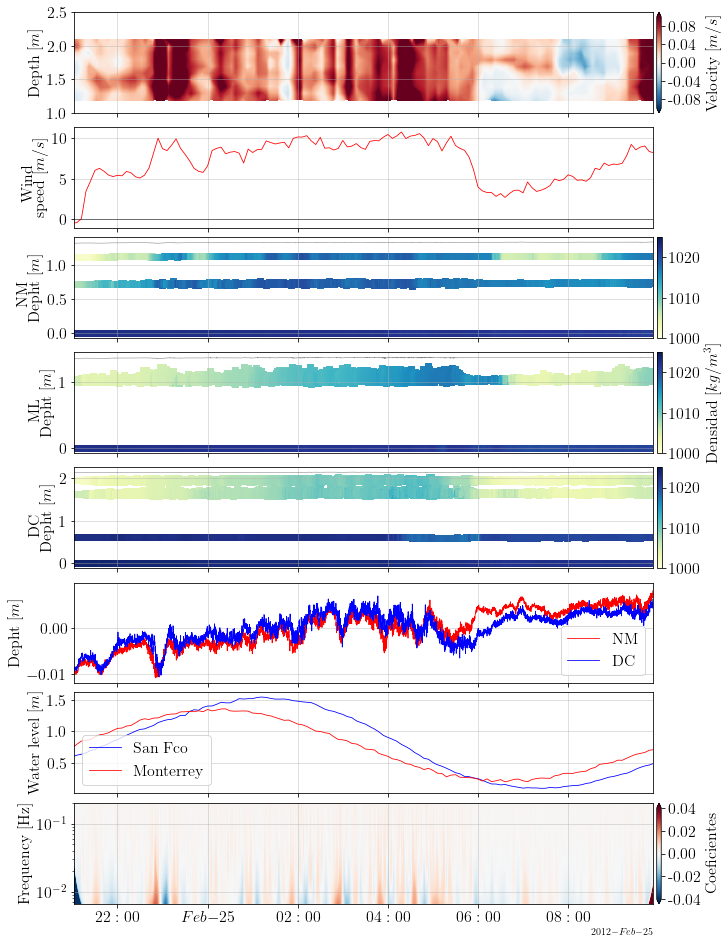

In [61]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 13), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
cbar.set_label("Velocity [$m/s$]", loc='center',
          fontsize=16)
ax1.set_ylabel(r"Depth "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"Wind \\ speed "
          r"$\displaystyle[m/s]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=16)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=16)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Depht $[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=16)
cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
ax7.legend(["San Fco", "Monterrey"], loc='lower left',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

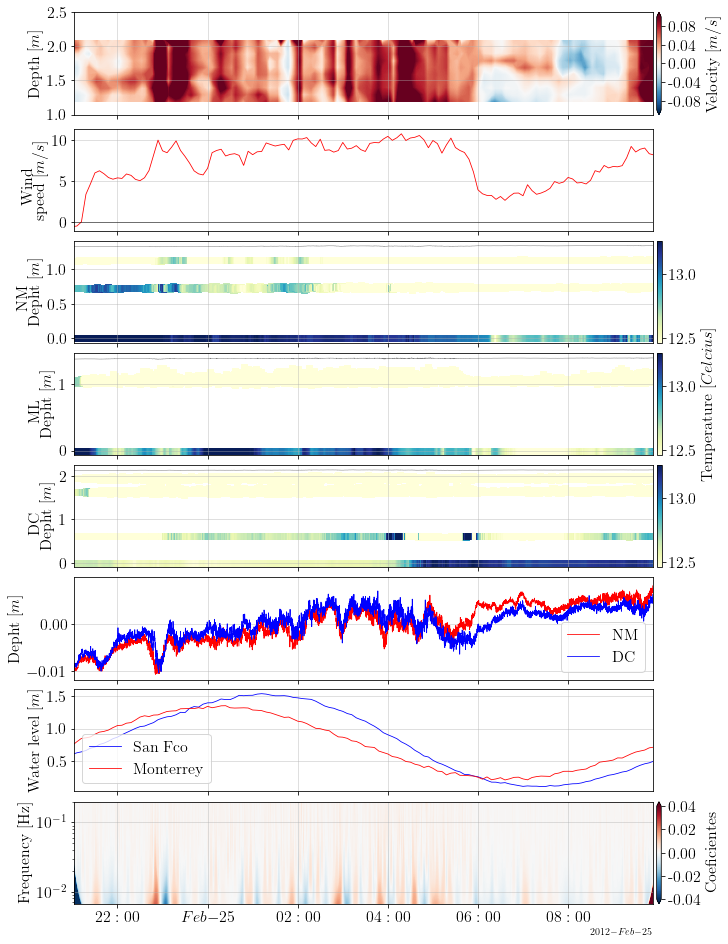

In [53]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 13), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
cbar.set_label("Velocity [$m/s$]", loc='center',
          fontsize=16)
ax1.set_ylabel(r"Depth "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"Wind \\ speed "
          r"$\displaystyle[m/s]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['Temperature'], marker='s', cmap=cm.YlGnBu, vmin=12.46, vmax=13.26)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['Temperature'], marker='s', cmap=cm.YlGnBu, vmin=12.46, vmax=13.26)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['Temperature'], marker='s', cmap=cm.YlGnBu, vmin=12.46, vmax=13.26)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['Temperature'], marker='s', cmap=cm.YlGnBu, vmin=12.46, vmax=13.26)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=16)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['Temperature'], marker='s', cmap=cm.YlGnBu, vmin=12.46, vmax=13.26)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['Temperature'], marker='s', cmap=cm.YlGnBu, vmin=12.46, vmax=13.26)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['Temperature'], marker='s', cmap=cm.YlGnBu, vmin=12.46, vmax=13.26)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=16)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Depht $[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['Temperature'], marker='s', cmap=cm.YlGnBu, vmin=12.46, vmax=13.26)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['Temperature'], marker='s', cmap=cm.YlGnBu, vmin=12.46, vmax=13.26)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=16)
cbar4.set_label("Temperature [$Celcius$]", loc='center',
          fontsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
ax7.legend(["San Fco", "Monterrey"], loc='lower left',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

In [ ]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 13), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
cbar.set_label("Velocity [$m/s$]", loc='center',
          fontsize=16)
ax1.set_ylabel(r"Depth "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"Wind \\ speed "
          r"$\displaystyle[m/s]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=16)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=16)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Depht $[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=16)
cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
ax7.legend(["San Fco", "Monterrey"], loc='lower left',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

<ipython-input-70-2dcf91c340a2>:54: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


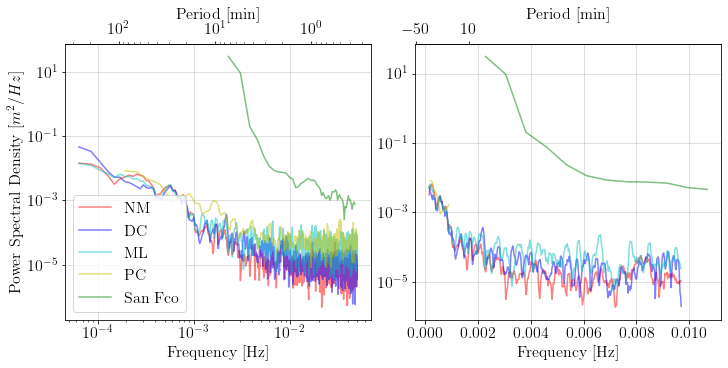

In [70]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='DC')
axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, label='ML')
axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, label='PC')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs4[sl], psd4[sl], 'c', 
              freqs5[sl4], psd5[sl4], 'y', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

## 26-Mar

In [36]:
bu2 = UV_burst.sel(time=slice("2012-02-25 21:00:00","2012-02-27 00:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,25,21,0,0):datetime.datetime(2012,2,27,0,0,0)]

In [37]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

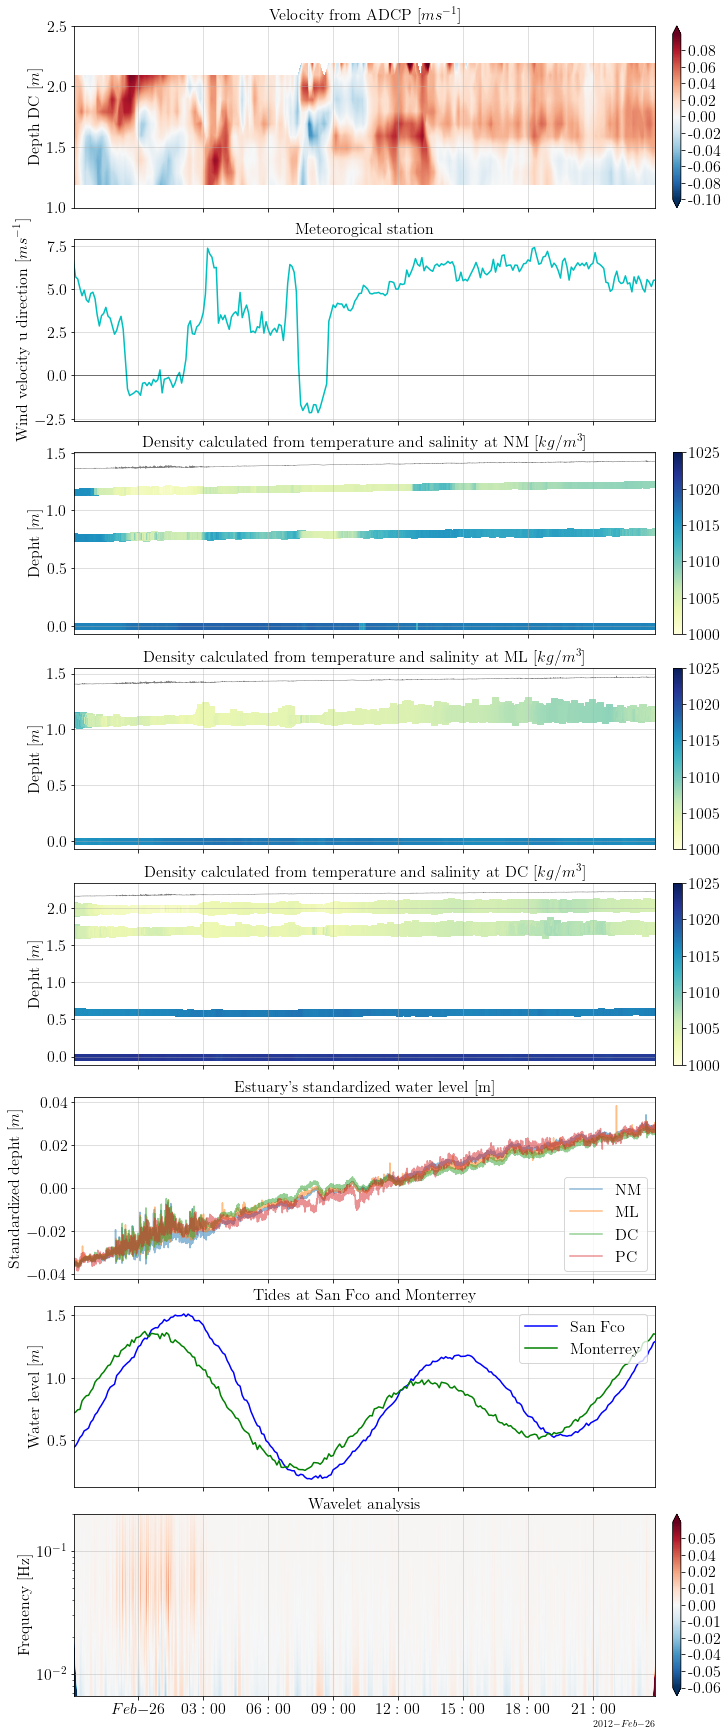

In [38]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 24), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada

ax6.set_title(r"Estuary's standardized water level [m]",
          fontsize=16)
ax6.set_ylabel(r"Standardized depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), alpha=0.5)
ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), alpha=0.5)
ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "ML", "DC", "PC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.06
umax = 0.06
vmin = -0.06
vmax = 0.06
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
ax8.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

- La boca está completamente cerrada
- Se observa wave overtopping al principio de la señal pero no domina el movimiento del estuario.
- Viento domina le movimiento dentro del estuario
- En NM se observa algo así como una oscilación en la densidad, lo cual podría ser resultado del esfuerzo de viento aplicado anteriormente.
- Los peaks de viento son de muy poca duración para afectar significativamente el movimiento del estuario. Hacer analisis wavelet para cachar cual es la duración minima que tiene que tener el viento para que haga algo.
- Al final los estratos se encuentran volviendo al equilibrio ya que la velocidad en el estrato más bajo está negativa.

<ipython-input-86-2dcf91c340a2>:54: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


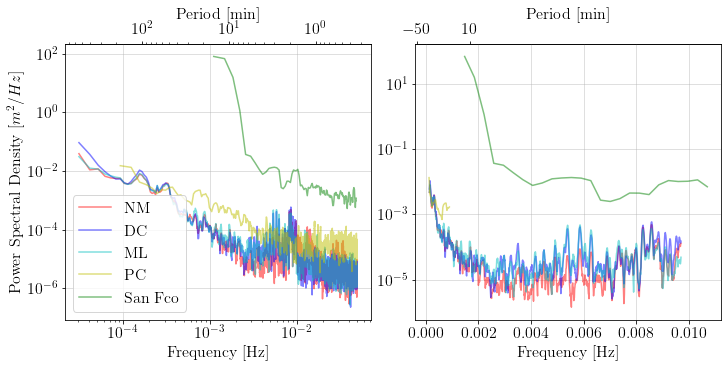

In [86]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='DC')
axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, label='ML')
axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, label='PC')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs4[sl], psd4[sl], 'c', 
              freqs5[sl4], psd5[sl4], 'y', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

## 27-Mar

In [39]:
bu2 = UV_burst.sel(time=slice("2012-02-27 00:00:00","2012-02-28 00:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,27,0,0,0):datetime.datetime(2012,2,28,0,0,0)]

In [40]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

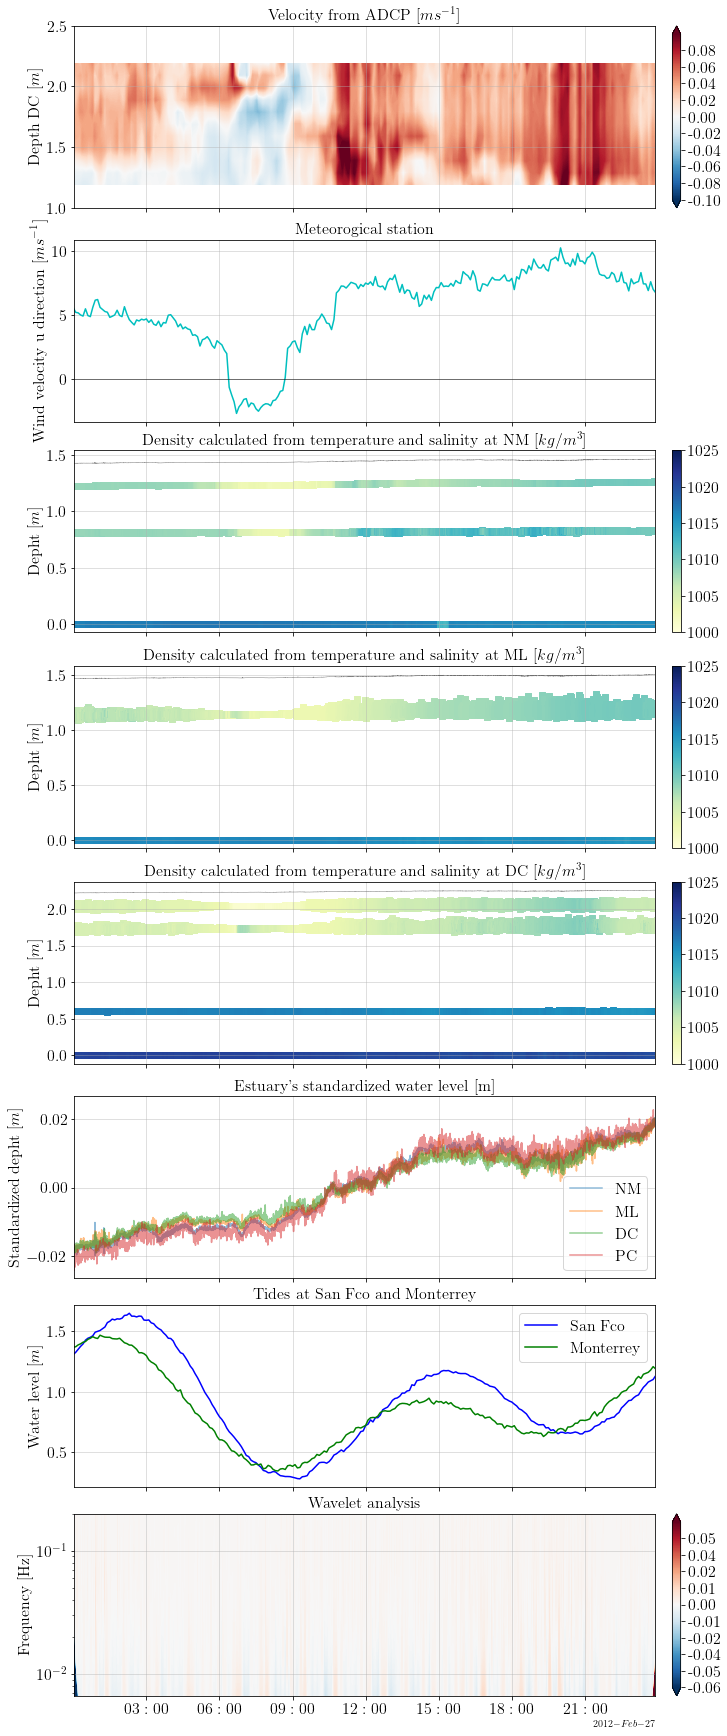

In [42]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 24), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada

ax6.set_title(r"Estuary's standardized water level [m]",
          fontsize=16)
ax6.set_ylabel(r"Standardized depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), alpha=0.5)
ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), alpha=0.5)
ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "ML", "DC", "PC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.06
umax = 0.06
vmin = -0.06
vmax = 0.06
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
ax8.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

- La boca está completamente cerrada
- No se observa wave overtopping.
- Viento domina el movimiento dentro del estuario
- Los cambios de densidad en la superficie se pueden deber a dos cosas:
    - Que el viento anterior era muy fuerte y provoca mezcla en los estratos, y por ende cuando deja de soplar vuelve al equilibrio
    - Que el cambio de direccion provoca upwelling en el otro sentido, pero no podemos verlo reflejado en los sensores ya que no hay datos aguas arriba.
- Al inicio, el agua del estrato más bajo se está llendo en dirección negativa, lo cual es debido a que la velocidad del viento en la superficie no es tan fuerte como para empujar ambos estratos.
- Al cambiar la velocidad los estratos vuelven a su equilibrio, ya que la velocidad negativa no es tan fuerte para afectar el movimiento del estuario significativamente.

<ipython-input-86-2dcf91c340a2>:54: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


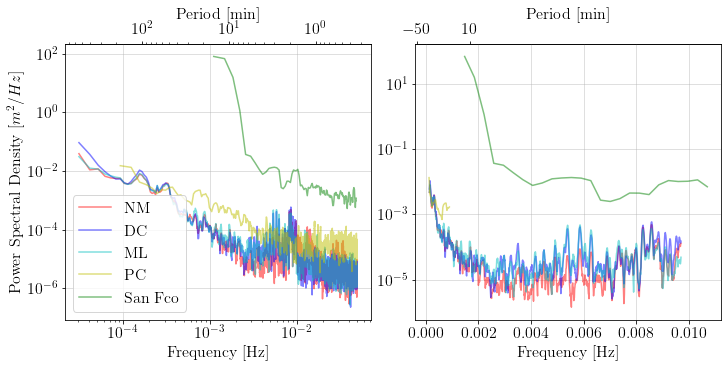

In [86]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='DC')
axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, label='ML')
axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, label='PC')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs3, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs4[sl], psd4[sl], 'c', 
              freqs5[sl4], psd5[sl4], 'y', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

## 28 Mar

In [47]:
bu2 = UV_burst.sel(time=slice("2012-02-28 00:00:00","2012-02-29 00:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,28,0,0,0):datetime.datetime(2012,2,29,0,0,0)]

In [48]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

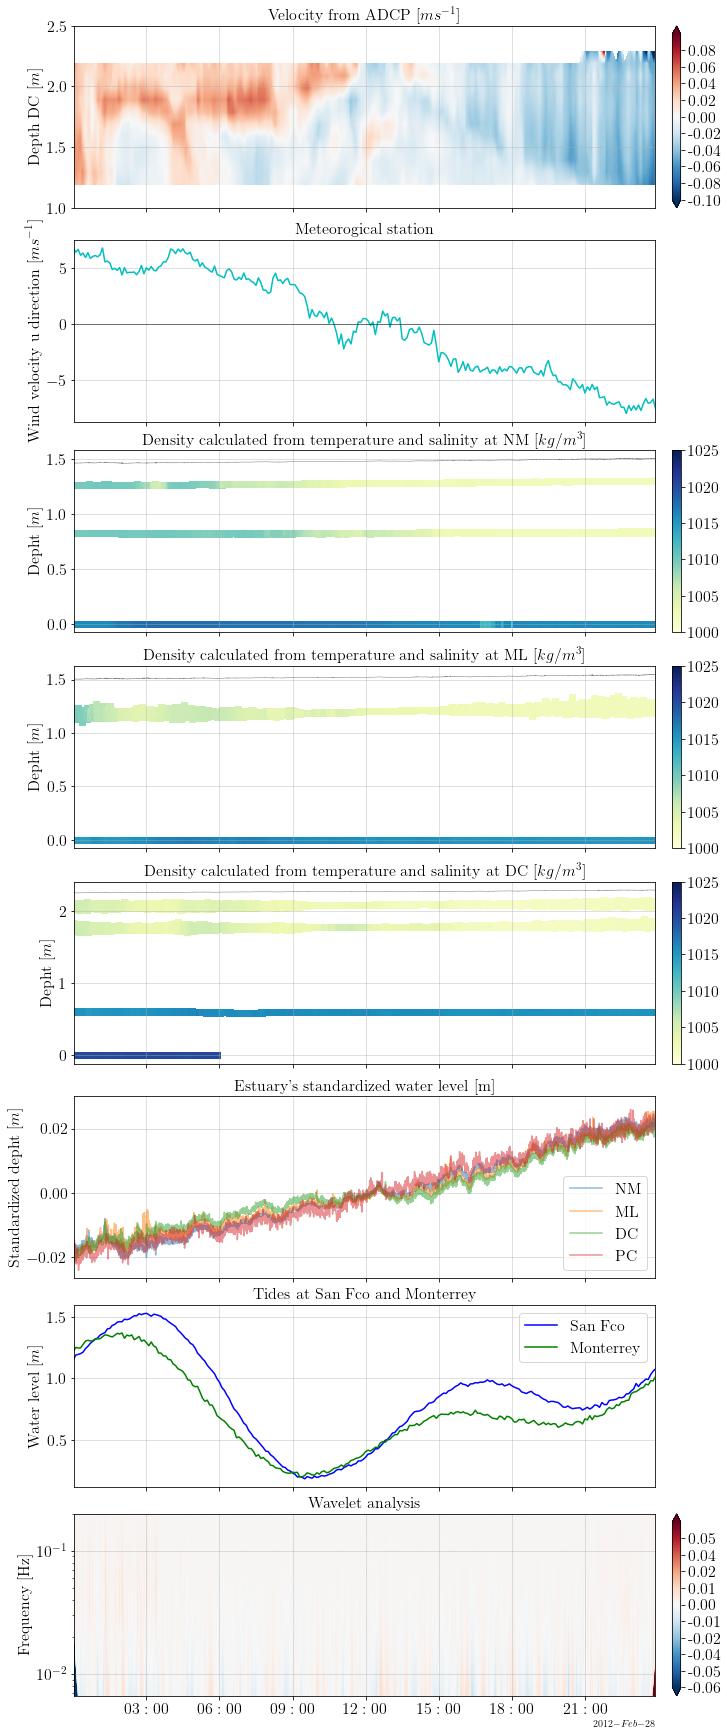

In [49]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 24), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada

ax6.set_title(r"Estuary's standardized water level [m]",
          fontsize=16)
ax6.set_ylabel(r"Standardized depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), alpha=0.5)
ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), alpha=0.5)
ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "ML", "DC", "PC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.06
umax = 0.06
vmin = -0.06
vmax = 0.06
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
ax8.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

- Hay un posible wave overtopping al principio de la señal.
- Viento domina el movimiento dentro del estuario
- Cuando el viento se detiene los estratos tienden a volver al equilibrio, por lo que se generan velocidades en velocidades contrarias entre estratos.
- Al final la dirección negativa del viento afecta todo el estuario.

<ipython-input-51-2dcf91c340a2>:54: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


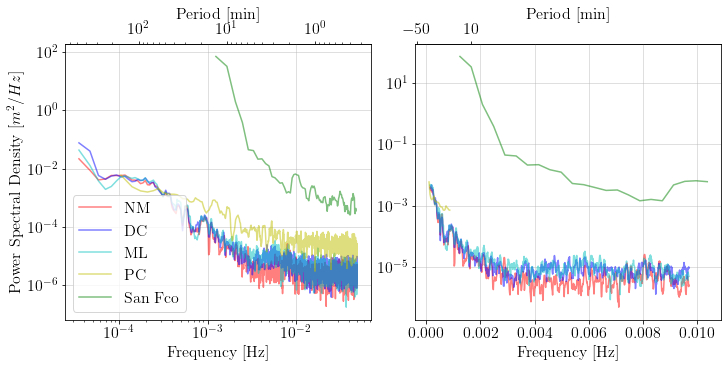

In [51]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='DC')
axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, label='ML')
axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, label='PC')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs4[sl], psd4[sl], 'c', 
              freqs5[sl4], psd5[sl4], 'y', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

## 29 Feb

In [64]:
bu2 = UV_burst.sel(time=slice("2012-02-28 19:30:00","2012-02-29 6:30:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]
sf = snfco.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]
mt = mnty.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)]

delta = Delta_nmdc.loc[datetime.datetime(2012,2,28,19,30,0):datetime.datetime(2012,2,29,6,30,0)] 

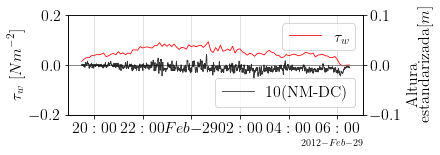

In [65]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2) = plt.subplots(nrows=1, figsize=(6, 2), constrained_layout=True, sharex=True)

ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.2, 0.2)
ax2.legend([r"$\tau_w$"], loc='upper right',
          fontsize=16);
ax6 = ax2.twinx()

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Altura\\estandarizada$[m]$",
          fontsize=16)
# ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
# ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
ax6.plot(delta.index, delta.values*10-0.11, linewidth=0.8, c="k", alpha=0.8)
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["10(NM-DC)"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)
ax6.set_ylim(-0.1, 0.1)
# Ajustar formato fecha


ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)


plt.show() 

In [66]:
bu2 = UV_burst.sel(time=slice("2012-02-28 12:00:00","2012-03-02 12:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)]

delta = Delta_nmdc.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,2,12,0,0)] 

In [67]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

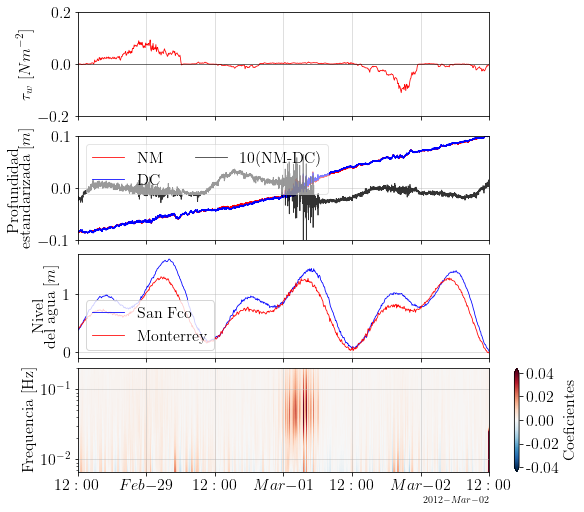

In [72]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax6, ax7, ax8) = plt.subplots(nrows=4, figsize=(8, 7), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
# contourf_ = ax1.contourf(bu2.time, y_bin,
#                          np.transpose(bu2.values),
#                          levels=level_boundaries_u,
#                          cmap=cm.RdBu_r,
#                          vmax=umax, vmin=umin, extend='both')
# cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
# cbar.ax.tick_params(labelsize=16)
# cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
# cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
# cbar.set_label("Velocidad [$m/s$]", loc='center',
#           fontsize=16)
# ax1.set_ylabel(r"DC\\Altura $[m]$",
#           fontsize=16)
# ax1.grid(alpha=0.5)
# ax1.set_ylim(0.71, 2.5)
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.yaxis.set_tick_params(labelsize=16)
# ax1.text(pd.to_datetime('2012-3-1 22:00:00'), 2.2, 'A',
#           fontsize=16)
# ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)
# ax2.text(pd.to_datetime('2012-3-1 22:00:00'), 0.008, 'B',
#           fontsize=16)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.2, 0.2)

# #Grafico de profundidad y densidad (color map) DC
# # ax3 = fig.add_subplot(gs[6, 0])
# # ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
# #           fontsize=16)
# ax3.set_ylabel(r"DC \\ Depht "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
# scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
# cbar2.ax.tick_params(labelsize=16)
# # cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
# #           fontsize=16)
# ax3.xaxis.set_tick_params(labelsize=16)
# ax3.yaxis.set_tick_params(labelsize=16)
# ax3.grid(alpha=0.5)

# # Grafico densidades NM
# # ax4 = fig.add_subplot(gs[4, 0])
# # ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
# #           fontsize=16)
# ax4.set_ylabel(r"NM\\Altura "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
# scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
# cbar3.ax.tick_params(labelsize=16)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
# ax4.xaxis.set_tick_params(labelsize=16)
# ax4.yaxis.set_tick_params(labelsize=16)
# ax4.grid(alpha=0.5)
# ax4.text(pd.to_datetime('2012-3-1 22:00:00'), 1.4, 'C',
#           fontsize=16)

# # Grafico densidades ML
# # ax5 = fig.add_subplot(gs[5, 0])
# # ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
# #           fontsize=16)
# ax5.set_ylabel(r"ML \\ Depht $[m]$",
#           fontsize=16)
# ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
# scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
# cbar4.ax.tick_params(labelsize=16)
# cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
# ax5.xaxis.set_tick_params(labelsize=16)
# ax5.yaxis.set_tick_params(labelsize=16)
# ax5.grid(alpha=0.5)

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Profundidad\\estandarizada "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
ax6.plot(delta.index, delta.values*10-0.11, linewidth=0.8, c="k", alpha=0.8)
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC", "10(NM-DC)"], loc='upper left',ncol=2,framealpha=0.5,
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)
ax6.set_ylim(-0.1, 0.1)
# ax6.text(pd.to_datetime('2012-3-1 22:00:00'), 0.07, 'D',
#           fontsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
ax7.set_ylabel(r"Nivel\\del agua "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
ax7.legend(["San Fco", "Monterrey"], loc='lower left',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)
# ax7.text(pd.to_datetime('2012-3-1 22:00:00'), 1.4, 'E',
#           fontsize=16)


#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequencia [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)
# ax8.text(pd.to_datetime('2012-3-1 22:00:00'), 10**-1, 'F',
#           fontsize=16)

# Ajustar formato fecha


ax6.xaxis.set_major_locator(locator)
ax6.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax7.xaxis.set_major_locator(locator)
ax7.xaxis.set_major_formatter(formatter)


plt.show() 

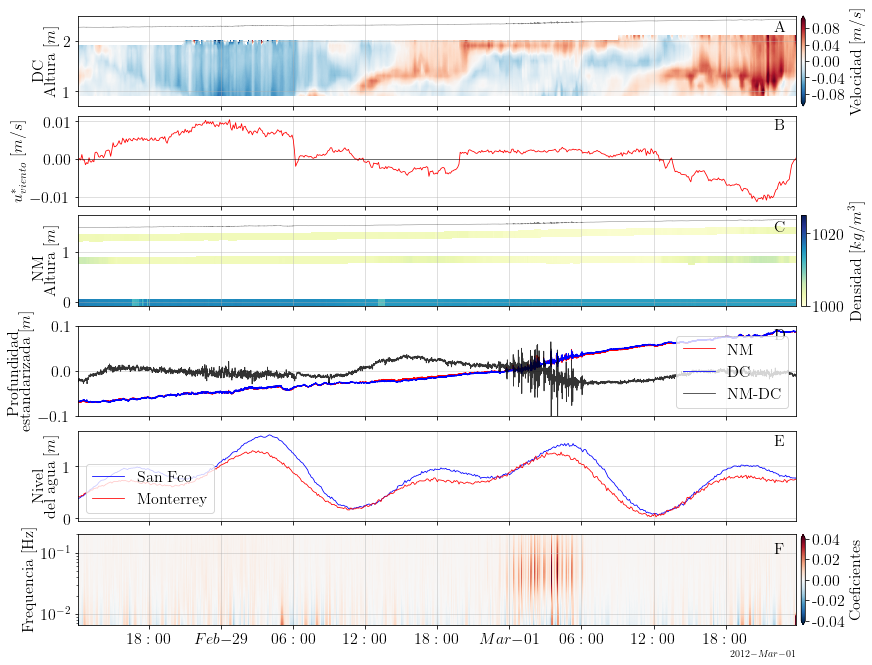

In [39]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax6, ax7, ax8) = plt.subplots(nrows=6, figsize=(12, 9), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
cbar.set_label("Velocidad [$m/s$]", loc='center',
          fontsize=16)
ax1.set_ylabel(r"DC\\Altura $[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(0.71, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.text(pd.to_datetime('2012-3-1 22:00:00'), 2.2, 'A',
          fontsize=16)
ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$u^*_{viento}$ "
          r"$\displaystyle[m/s]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)
ax2.text(pd.to_datetime('2012-3-1 22:00:00'), 0.008, 'B',
          fontsize=16)

# #Grafico de profundidad y densidad (color map) DC
# # ax3 = fig.add_subplot(gs[6, 0])
# # ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
# #           fontsize=16)
# ax3.set_ylabel(r"DC \\ Depht "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
# scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
# cbar2.ax.tick_params(labelsize=16)
# # cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
# #           fontsize=16)
# ax3.xaxis.set_tick_params(labelsize=16)
# ax3.yaxis.set_tick_params(labelsize=16)
# ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM\\Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=16)
cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)
ax4.text(pd.to_datetime('2012-3-1 22:00:00'), 1.4, 'C',
          fontsize=16)

# # Grafico densidades ML
# # ax5 = fig.add_subplot(gs[5, 0])
# # ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
# #           fontsize=16)
# ax5.set_ylabel(r"ML \\ Depht $[m]$",
#           fontsize=16)
# ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
# scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
# cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
# cbar4.ax.tick_params(labelsize=16)
# cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
# ax5.xaxis.set_tick_params(labelsize=16)
# ax5.yaxis.set_tick_params(labelsize=16)
# ax5.grid(alpha=0.5)

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Profundidad\\estandarizada "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), linewidth=0.8, c="b")
ax6.plot(delta.index, delta.values*10-0.11, linewidth=0.8, c="k", alpha=0.8)
# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC", "NM-DC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)
ax6.set_ylim(-0.1, 0.1)
ax6.text(pd.to_datetime('2012-3-1 22:00:00'), 0.07, 'D',
          fontsize=16)

# Grafico nivel del agua SF
# ax7 = fig.add_subplot(gs[9, 0])
# ax7.set_title(r"Tides at San Fco and Monterrey",
#           fontsize=16)
ax7.set_ylabel(r"Nivel\\del agua "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b', linewidth=0.8)
ax7.plot(mt.index, mt.values, c='r', linewidth=0.8)
ax7.legend(["San Fco", "Monterrey"], loc='lower left',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)
ax7.text(pd.to_datetime('2012-3-1 22:00:00'), 1.4, 'E',
          fontsize=16)

#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
# ax8 = fig.add_subplot(gs[10:13, 010:13])
# ax8.set_title(r"Wavelet analysis",
#           fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.007)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.02))
cbar.set_label("Coeficientes", loc='center',
          fontsize=16)
ax8.set_ylabel(r"Frequencia [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
# ax8.set_ylim(10**-3, 1)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)
ax8.text(pd.to_datetime('2012-3-1 22:00:00'), 10**-1, 'F',
          fontsize=16)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

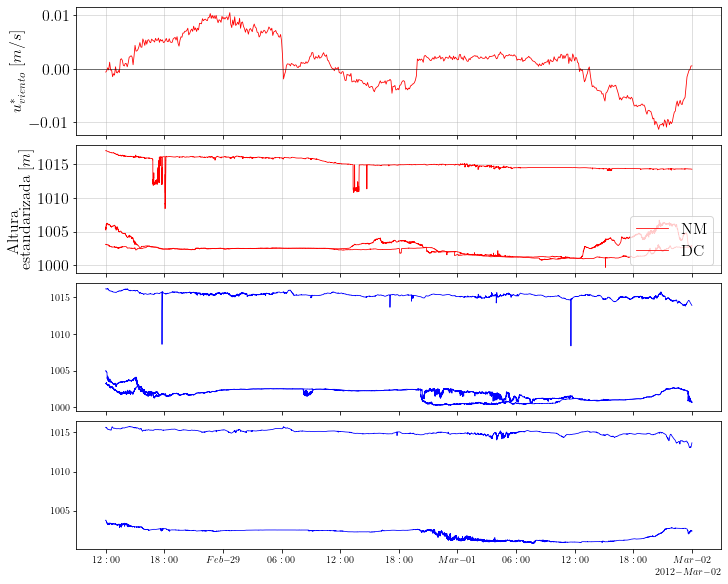

In [42]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax6, ax7, ax8) = plt.subplots(nrows=4, figsize=(10, 8), constrained_layout=True, sharex=True)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$u^*_{viento}$ "
          r"$\displaystyle[m/s]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# Grafico water level estandarizada
# ax6 = fig.add_subplot(gs[6:9, 0])
# ax6.set_title(r"Estuary's standardized water level [m]",
#           fontsize=16)
ax6.set_ylabel(r"Altura\\estandarizada "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['densidad'], linewidth=0.8, c="r")
ax6.plot(nm2.index, nm2['densidad'], linewidth=0.8, c="r")
ax6.plot(nm3.index, nm3['densidad'], linewidth=0.8, c="r")
# ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax7.plot(dc1.index, dc1['densidad'], linewidth=0.8, c="b")
ax7.plot(dc2.index, dc2['densidad'], linewidth=0.8, c="b")
ax7.plot(dc3.index, dc3['densidad'], linewidth=0.8, c="b")
ax7.plot(dc4.index, dc4['densidad'], linewidth=0.8, c="b")

ax8.plot(ml1.index, ml1['densidad'], linewidth=0.8, c="b")
ax8.plot(ml2.index, ml2['densidad'], linewidth=0.8, c="b")

# ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "DC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

In [97]:
bu2 = UV_burst.sel(time=slice("2012-02-28 12:00:00","2012-03-01 00:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,28,12,0,0):datetime.datetime(2012,3,1,0,0,0)]

In [98]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

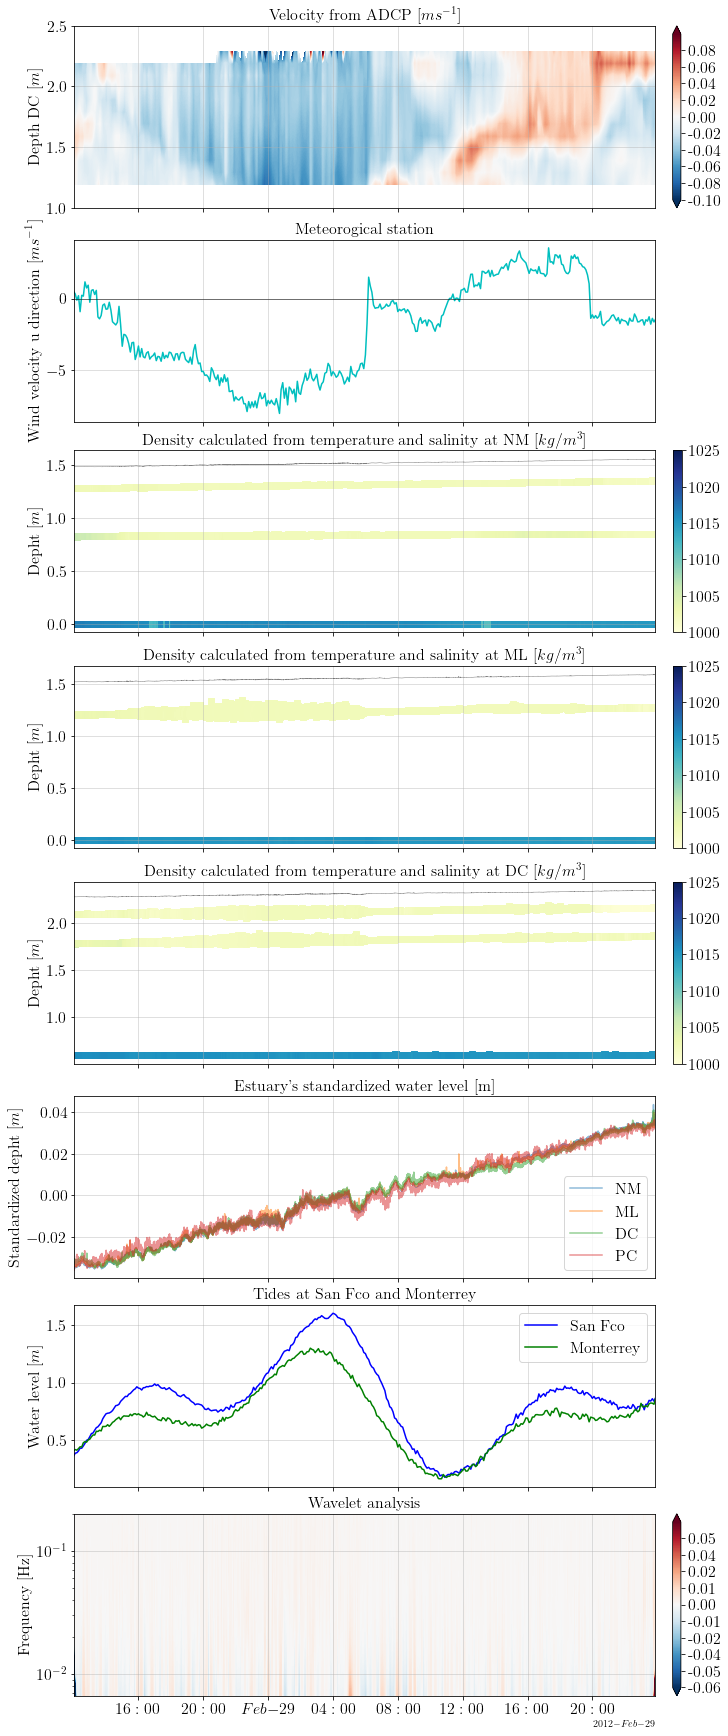

In [88]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 24), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada

ax6.set_title(r"Estuary's standardized water level [m]",
          fontsize=16)
ax6.set_ylabel(r"Standardized depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), alpha=0.5)
ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), alpha=0.5)
ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "ML", "DC", "PC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.06
umax = 0.06
vmin = -0.06
vmax = 0.06
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
ax8.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

- No se observa wave overtopping.
- Viento domina el movimiento dentro del estuario
- Cuando el viento se detiene se observan oscilaciones en la superficie, aunque no se observan a nivel de densidad ni de velocidades.
- Cuando el viento cambia de dirección se observan cambios de velocidades en los estratos.

<ipython-input-116-9bc55c37c67f>:61: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


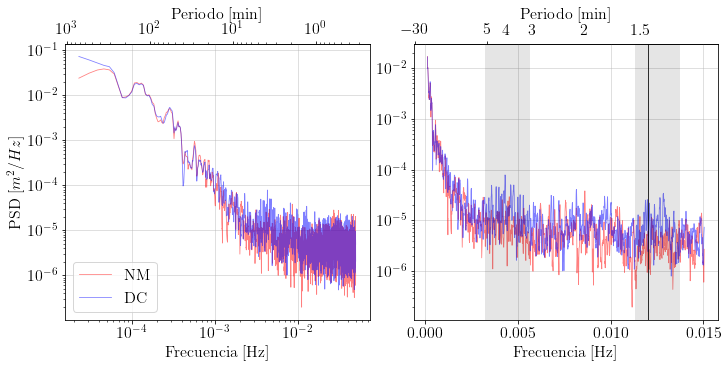

In [116]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, linewidth=0.8, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, linewidth=0.8, label='DC')
# axs[0].loglog(freqs3, psd3, 'c', alpha=0.5, linewidth=0.8, label='sf')
# axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, linewidth=0.8, label='ML')
# axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, linewidth=0.8, label='PC')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 1.50464135e-02])
i04, i14 = np.searchsorted(freqs5, [1.31969058e-04, 9.70464135e-03])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', alpha=0.5, linewidth=0.8)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('PSD [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frecuencia [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frecuencia [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)
axs[1].axvline(x=0.012, color='k', linewidth=0.8)
axs[1].axvline(x=0.0044, color='k', linewidth=45, alpha=0.1)
axs[1].axvline(x=0.0125, color='k', linewidth=45, alpha=0.1)
axs[1].text(0.008333, 0.045, '2',
          fontsize=16)
axs[1].text(0.005555, 0.045, '3',
          fontsize=16)
axs[1].text(0.004166, 0.045, '4',
          fontsize=16)
axs[1].text(0.011111, 0.045, '1.5',
          fontsize=16)

def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Periodo [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Periodo [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

In [119]:
(nm1["Depth"].mean()+dc1["Depth"].mean()+ml1["Depth"].mean())/3

1.7918035750222288

## 1 Mar

In [57]:
bu2 = UV_burst.sel(time=slice("2012-03-01 00:00:00","2012-03-02 00:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]
sf = snfco.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]
mt = mnty.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,3,1,0,0,0):datetime.datetime(2012,3,2,0,0,0)]

In [58]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

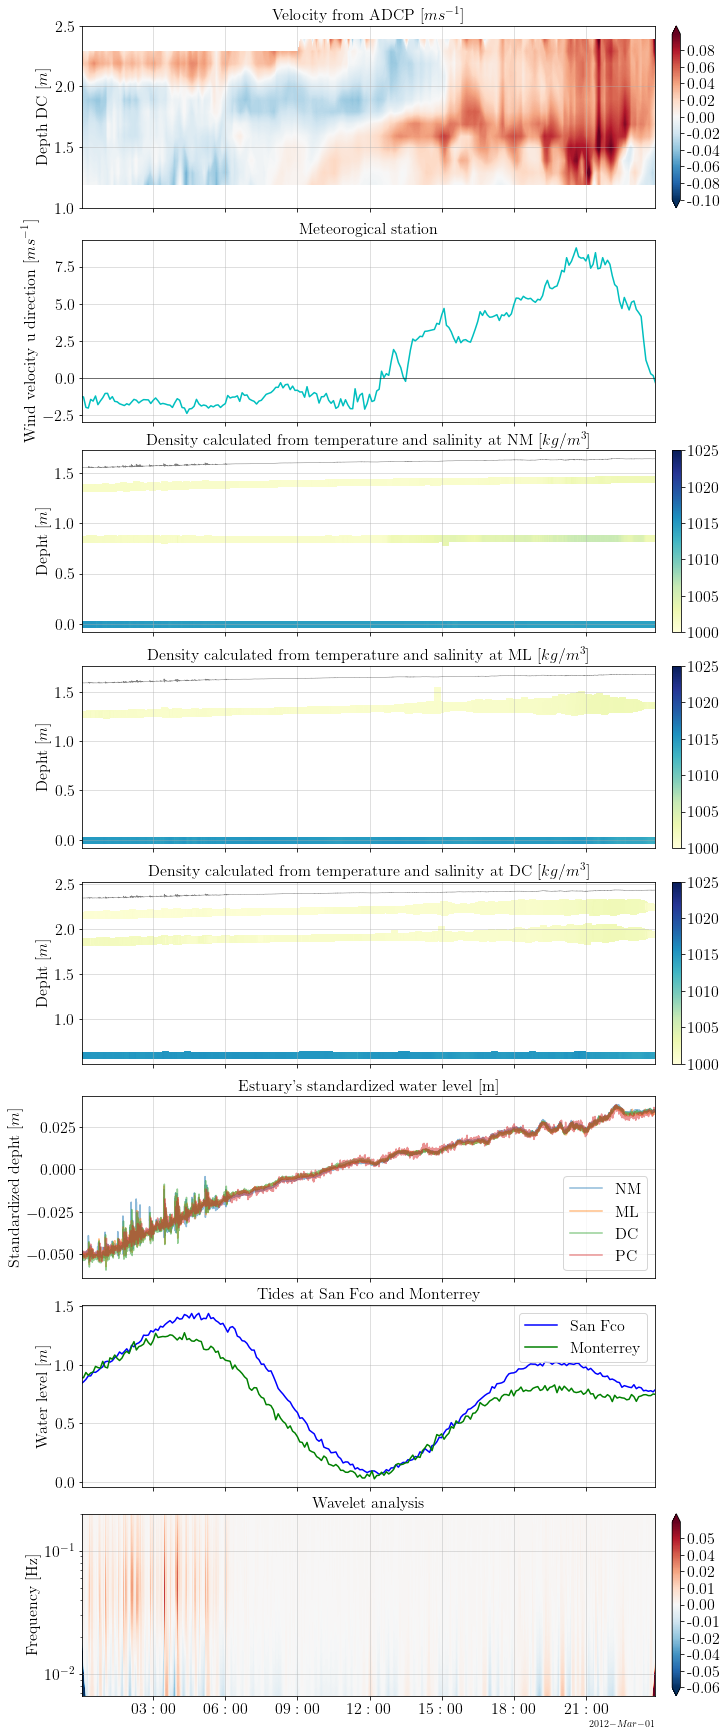

In [59]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 24), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada

ax6.set_title(r"Estuary's standardized water level [m]",
          fontsize=16)
ax6.set_ylabel(r"Standardized depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), alpha=0.5)
ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), alpha=0.5)
ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "ML", "DC", "PC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.06
umax = 0.06
vmin = -0.06
vmax = 0.06
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
ax8.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

- Se observa wave overtopping al principio de los datos, aún así el viento domina el movimiento dentro del estuario.
- Cuando aumenta la velocidad se observa un aumento en la densidad en uno de los estratos superiores de NM, mostrando que el estrato inferior está subiendo en ese punto pero en los demás no.

<ipython-input-60-2dcf91c340a2>:54: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


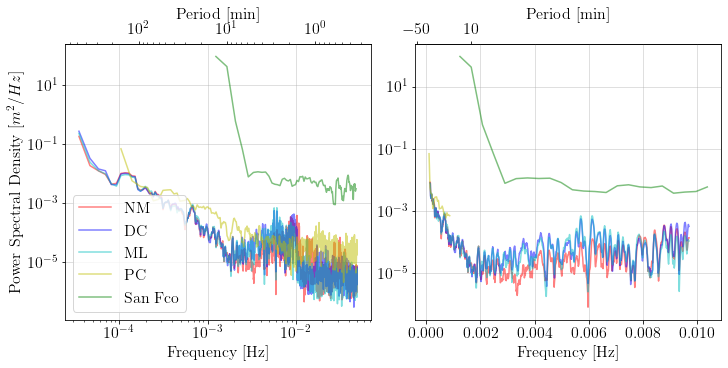

In [60]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='DC')
axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, label='ML')
axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, label='PC')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs4[sl], psd4[sl], 'c', 
              freqs5[sl4], psd5[sl4], 'y', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

## 1 Mar

In [29]:
bu2 = UV_burst.sel(time=slice("2012-03-01 09:00:00","2012-03-02 09:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]
sf = snfco.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]
mt = mnty.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,3,1,9,0,0):datetime.datetime(2012,3,2,9,0,0)]

In [30]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

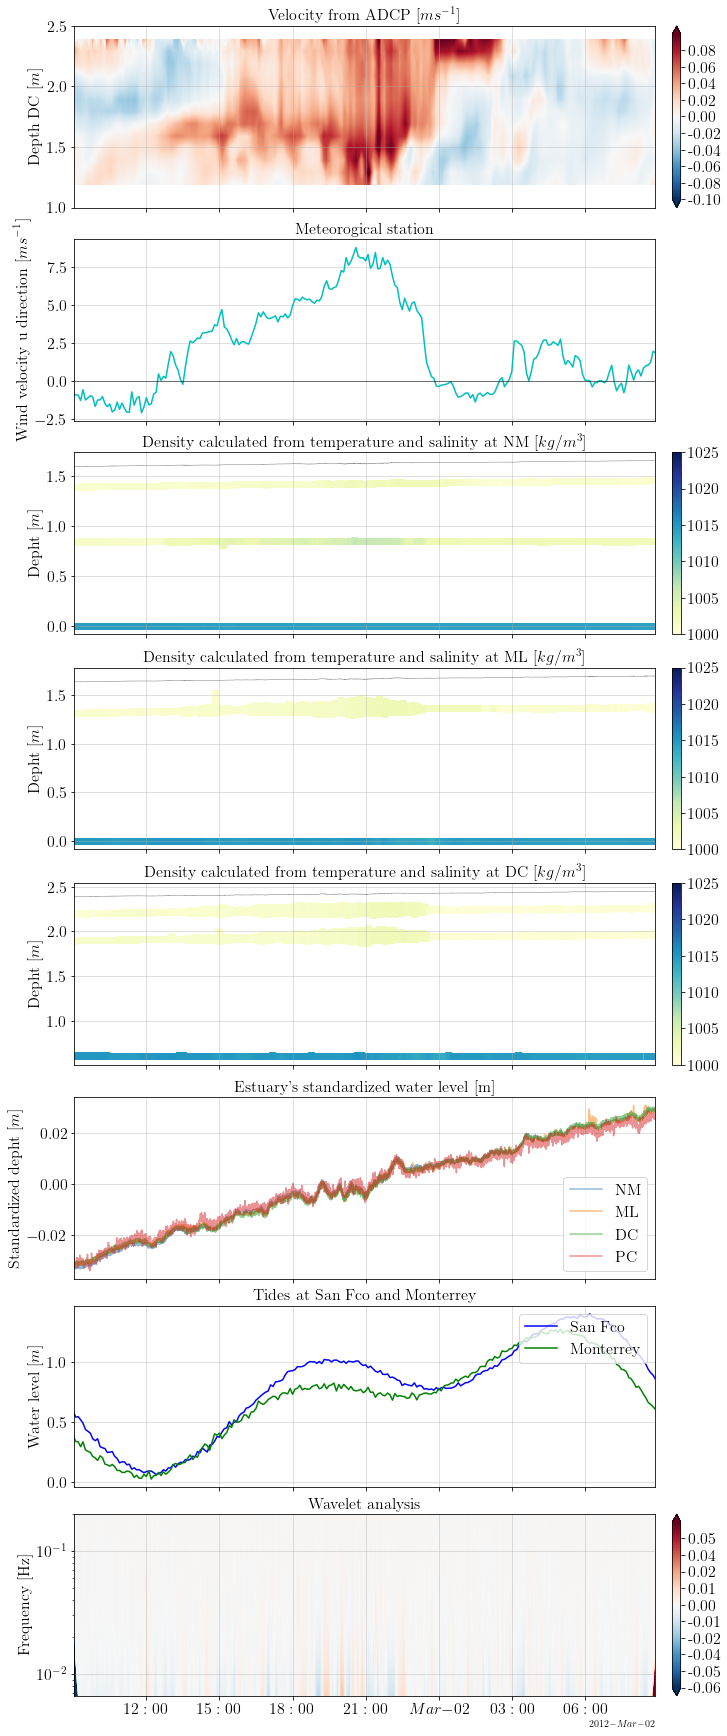

In [31]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 24), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada

ax6.set_title(r"Estuary's standardized water level [m]",
          fontsize=16)
ax6.set_ylabel(r"Standardized depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), alpha=0.5)
ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), alpha=0.5)
ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "ML", "DC", "PC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.06
umax = 0.06
vmin = -0.06
vmax = 0.06
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
ax8.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

- Se observa wave overtopping al principio de los datos, aún así el viento domina el movimiento dentro del estuario.
- Cuando aumenta la velocidad se observa un aumento en la densidad en uno de los estratos superiores de NM, mostrando que el estrato inferior está subiendo en ese punto pero en los demás no.

<ipython-input-60-2dcf91c340a2>:54: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


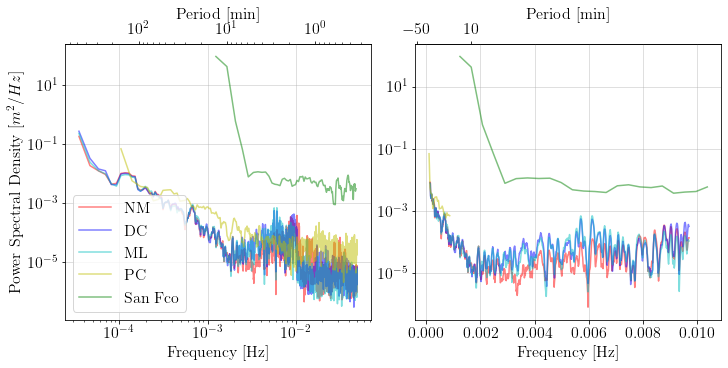

In [60]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='DC')
axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, label='ML')
axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, label='PC')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs4[sl], psd4[sl], 'c', 
              freqs5[sl4], psd5[sl4], 'y', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

## 2 Mar

In [61]:
bu2 = UV_burst.sel(time=slice("2012-03-02 00:00:00","2012-03-03 00:00:00")).u
wdf = dfw['u'].loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]
sf = snfco.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]
mt = mnty.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,3,2,0,0,0):datetime.datetime(2012,3,3,0,0,0)]

In [62]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

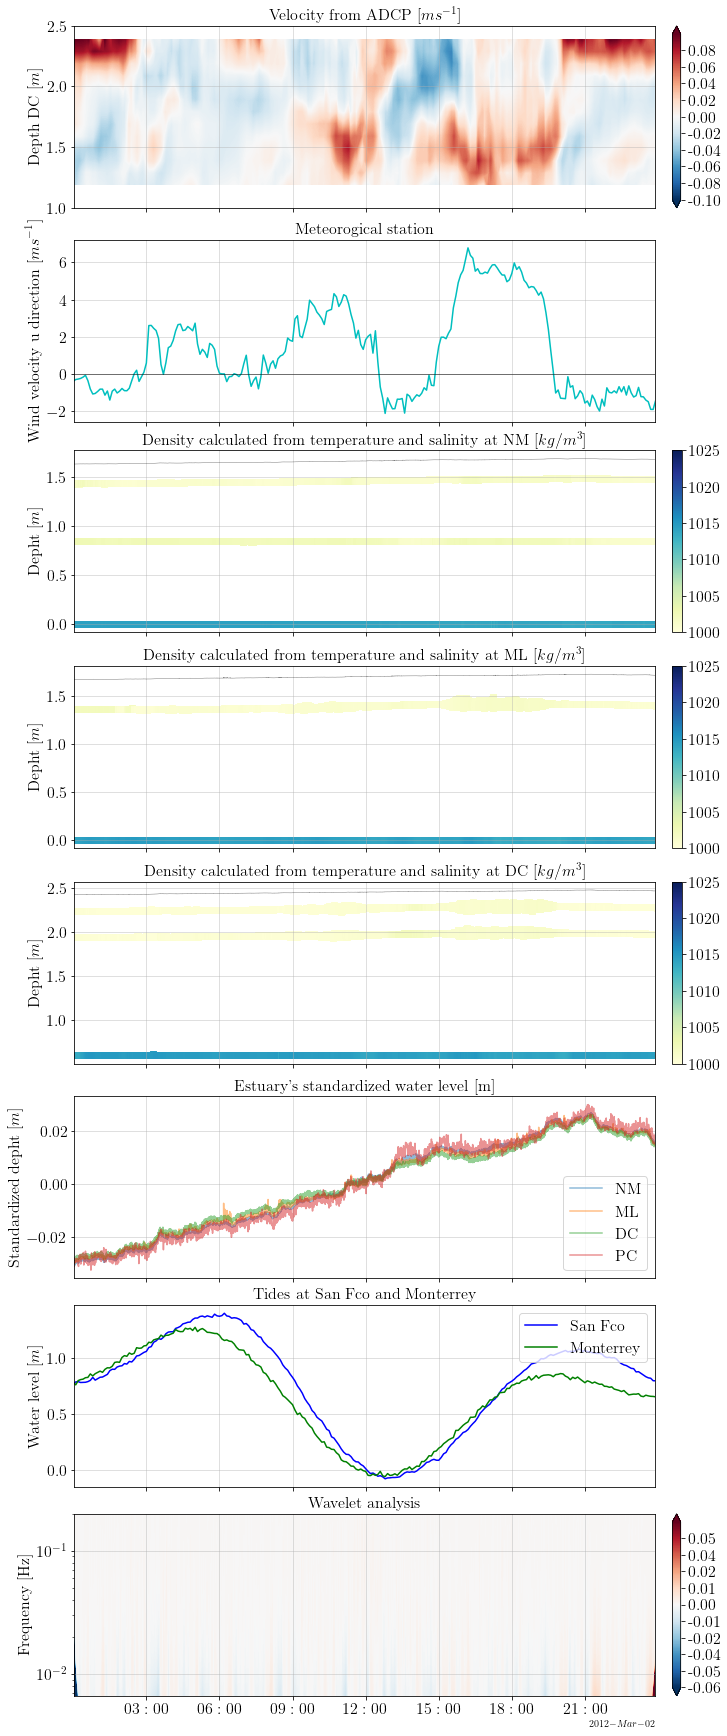

In [63]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 24), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada

ax6.set_title(r"Estuary's standardized water level [m]",
          fontsize=16)
ax6.set_ylabel(r"Standardized depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), alpha=0.5)
ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), alpha=0.5)
ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "ML", "DC", "PC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

#Ajustar limites colorbar
umin = -0.06
umax = 0.06
vmin = -0.06
vmax = 0.06
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Grafico de velocidad del agua (color map)
ax8.set_title(r"Wavelet analysis",
          fontsize=16)
contourf_ = ax8.contourf(dc1.index, freqs,
                         coef,
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax8, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax8.set_ylabel(r"Frequency [Hz] ",
          fontsize=16)
ax8.grid(alpha=0.5)
#    ax1.set_ylim(1, 2.5)
ax8.xaxis.set_tick_params(labelsize=16)
ax8.yaxis.set_tick_params(labelsize=16)
ax8.set_yscale("log")
# Ajustar formato fecha
ax8.xaxis.set_major_locator(locator)
ax8.xaxis.set_major_formatter(formatter)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

- No se observa wave overtopping.
- Viento domina el movimiento dentro del estuario
- Se observan muchas cambios de dirección del viento lo que provoca muchos cambios de velocidades, pero quizás no lo suficiente para provocar un upwelling tan pronunciado.
- Se observa al principio y al final un aumento en la velocidad de la superficie, donde podría haber una fuga de agua por encima de la barra de arena.


<ipython-input-65-2dcf91c340a2>:54: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


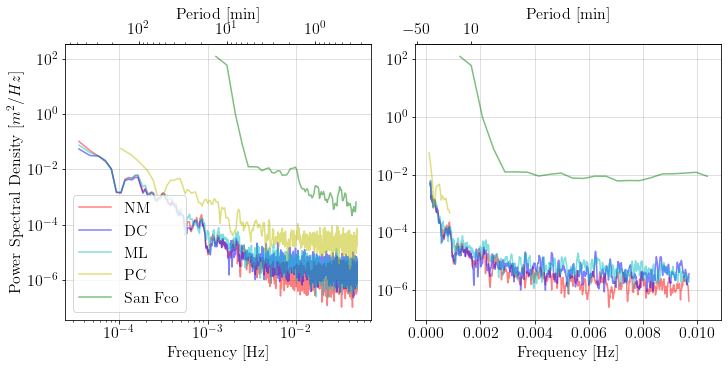

In [65]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=360)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=30)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='DC')
axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, label='ML')
axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, label='PC')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs4[sl], psd4[sl], 'c', 
              freqs5[sl4], psd5[sl4], 'y', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()